# Implémentez un modèle de scoring


Etude data - Projet 7 - fevrier 2023

*Data source* : [Jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.\
**On s'interresera surtout au recall car on voudrait pas accorder un credit à un client qui ne sera pas capable de rembourser**: La sensibilité (recall) mesure la capacité du modèle à détecter les clients réellement négatifs, c'est-à-dire ceux qui présentent un risque de défaut de crédit. Une sensibilité élevée est généralement souhaitable dans le contexte du scoring de crédit, car cela signifie que le modèle identifie efficacement les clients présentant un risque élevé.

In [1]:
import sys
#print(sys.executable)

In [2]:
#pip show requests-mock

In [3]:
#!{sys.executable} -m pip install pygwalker -q

In [4]:
!python --version

Python 3.9.16


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import joblib
import pickle
from zipfile import ZipFile

import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, roc_curve 

from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate, KFold, StratifiedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import fbeta_score, confusion_matrix

from sklearn.feature_selection import RFECV

from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
# Fixeons la graine aléatoire pour NumPy
np.random.seed(42)

In [7]:
# import matplotlib
# print(matplotlib.__version__)

In [8]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':11,
     'ytick.labelsize':11,
     'axes.labelsize': 11,
     'legend.fontsize': 11,
     'axes.titlesize':11,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## 1. Chargement des data sets:

Une étude de corrélation a été effectuée sur le notebook exploration et on avait constaté qu'il y avait des variables fortement correlées.
On utilise ici le data sets que l'on a rétiré la corrélation des variables explicatives.

In [12]:
def load_data(path):
    # Tente de charger le fichier comme un CSV zippé
    try:
        data = pd.read_csv(path, compression='zip')
    except:
        # Si cela échoue, tente de charger comme un CSV normal
        data = pd.read_csv(path)
    return data

In [10]:
path_new_data = "C:/Users/aella/Desktop/P7_Abdoullatuf_Maoulida/Data_P7/New_data/"

In [14]:
# Charger les données
df = load_data(path_new_data + 'df_train.zip')

# données test
df_test = load_data(path_new_data + 'df_test.zip')

In [18]:
target = load_data(path_new_data + 'TARGET.csv')

In [16]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
df.head()

Aperçu des premières lignes du DataFrame :


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,0.018801,9461.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,0.003541,16765.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,0.010032,19046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,0.008019,19005.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,0.028663,19932.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
target.head()

,SK_ID_CURR,TARGET
0,100002,1.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0


In [13]:
# import pygwalker as pyg  #pour importer "TABLEAU"
# pyg.walk(df, dark = 'light')

Pour plus de compréhensibilité, nous allons échanger les valeurs de la colonne "TARGET": 0 en 1 et 1 en 0; ce qui sera plus compréhensible pour moi que 0 le client\
n'a pas pu rembourser son credit ou a manqué ses échéances: 
- 0: négatif (le client est non solvable)
- 1: positif (le client est solvable: qui a les moyens de payer, qui peut respecter ses engagements financiers)

In [21]:
target["TARGET"].replace({0: 1, 1: 0}, inplace=True)

In [22]:
target.head()

,SK_ID_CURR,TARGET
0,100002,0.0
1,100003,1.0
2,100004,1.0
3,100006,1.0
4,100007,1.0


### Chargement des fonctions pour toutes les étapes impliquées dans le cycle de vie complet du future modèle:

In [23]:
from Fonctions_projet7 import *

# data_cleaning(data);     training_basic_classifier(X_train,y_train);     predict_on_test_data(model,X_test)

# predict_prob_on_test_data(model,X_test);       get_metrics(y_true, y_pred, y_pred_prob)

# create_confusion_matrix_plot(clf, X_test, y_test, seuil=0); create_roc_auc_plot(model, X_test, y_test)

#  hyper_parameter_tuning_rfc(X_train, y_train);        evaluate_model(modele, hyperparametres, seuil)

def create_confusion_matrix_plot(clf, X_test, y_test, seuil=0.5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    #plot_confusion_matrix(clf, X_test, y_test) # à changer pour fixer un seuil
    

    pred = clf.predict_proba(X_test)[:, 1]

    pred_1 = np.where(pred > seuil, 1, 0)
 
  
    cm = confusion_matrix(y_test, pred_1)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Negatives(TN) = ', cm[0, 0])
    print('\nTrue Positives(TP)=', cm[1, 1])
    print('\nFalse Positives(FP) = ', cm[0, 1])
    print('\nFalse Negatives(FN)= ', cm[1, 0])

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0', 'Actual Positive:1'],
                             index=['Predict Negative:0', 'Predict Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [24]:
import re

# Définir une fonction qui prend une chaîne de caractères en entrée et renvoie une chaîne de caractères sans caractères spéciaux, non supportés par JSON et espaces
def clean_column_name(col_name):
    col_name = re.sub(r"[^a-zA-Z0-9_]+", "", col_name) # Remplacer les caractères spéciaux par ""
    col_name = re.sub(r"\s+", "_", col_name) # Remplacer les espaces par "_"
    if col_name[0].isdigit(): # Ajouter un préfixe "_" si le nom de colonne commence par un chiffre
        col_name = "_" + col_name
    return col_name

# Utiliser la méthode rename() pour renommer toutes les colonnes du dataframe
df = df.rename(columns=clean_column_name)

In [25]:
df_test = df_test.rename(columns=clean_column_name)

In [26]:
# Définissons 'SK_ID_CURR' comme index pour le DataFrame original (df)
df = df.set_index('SK_ID_CURR')
df_test = df_test.set_index('SK_ID_CURR')
target = target.set_index('SK_ID_CURR')

In [30]:
target.head(2)

,TARGET
SK_ID_CURR,
100002,0.0
100003,1.0


In [31]:
target['TARGET']

SK_ID_CURR
100002    0.0
100003    1.0
100004    1.0
100006    1.0
100007    1.0
         ... 
456251    1.0
456252    1.0
456253    1.0
456254    0.0
456255    1.0
Name: TARGET, Length: 307511, dtype: float64

### Séparation du data set en train set et test set:

In [32]:
from sklearn.model_selection import train_test_split

seed = 42

# Séparation des caractéristiques (X) et de la variable cible (y)
X = df
y = target['TARGET']


# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)



# Vérification des formes des ensembles d'entraînement et de test
print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)
print("Shape de y_train :", y_train.shape)
print("Shape de y_test :", y_test.shape)

Shape de X_train : (246008, 277)
Shape de X_test : (61503, 277)
Shape de y_train : (246008,)
Shape de y_test : (61503,)


In [33]:
# Afficher la distribution de la variable cible
print("Distribution de la variable cible :")
print(target['TARGET'].value_counts()/target.shape[0])

Distribution de la variable cible :
1.0    0.919271
0.0    0.080729
Name: TARGET, dtype: float64


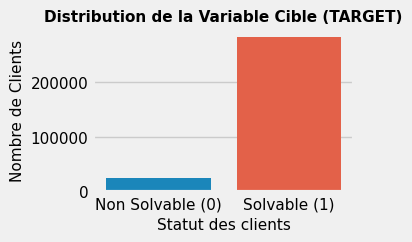

In [34]:
fig = plt.figure(figsize=(3, 2))
sns.countplot(x = target['TARGET'])

# Ajouter des titres et des étiquettes
plt.title('Distribution de la Variable Cible (TARGET)')
plt.xlabel('Statut des clients')
plt.ylabel('Nombre de Clients')
plt.xticks([0, 1], ['Non Solvable (0)', 'Solvable (1)'])

# Afficher le graphique
plt.show()

On observe un déséquilibre très important sur les classes. On pensera donc à reéquilibrer les données d'entrainement:

### **Baseline model - Logistic Regression, Dummy Regressor**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba ,input_data ,feature_importances, seuil):
    '''This function will make a pretty plot of 
    an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.
    The threshold (seuil) here is the probability that a customer will repay his credit, 
    therefore classified as positive (or 1)'''
    if seuil:
        
        binary_pred = np.where(y_pred_proba > seuil, 1, 0)
    
        pred = binary_pred
    else:
        pred = y_pred_proba
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    #tn, fp, fn, tp
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True labels')
    plt.xlabel('Predict Labels')

    plt.subplot(222)
    roc_auc = roc_auc_score(y_true, pred ) #y_pred_proba
    fpr, tpr, _ = roc_curve(y_true, pred)   #y_pred_proba 
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    if input_data is not None and not input_data.empty and feature_importances:
        # Drop the columns if they exist in input_data
        if "SK_ID_CURR" in input_data.columns:
            input_data = input_data.drop(["SK_ID_CURR"], axis=1)
        if "TARGET" in input_data.columns:
            input_data = input_data.drop(["TARGET"], axis=1)
        
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(input_data.columns[indices[i]]) #After RFECV selection > X_data created
        
        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

    plt.show()

In [36]:
%%time
from sklearn.linear_model import LogisticRegression
# Définition et entraînement du modèle de régression 
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC : 0.6344
              precision    recall  f1-score   support

         0.0       0.25      0.00      0.00      4949
         1.0       0.92      1.00      0.96     56554

    accuracy                           0.92     61503
   macro avg       0.58      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503

Wall time: 11.5 s


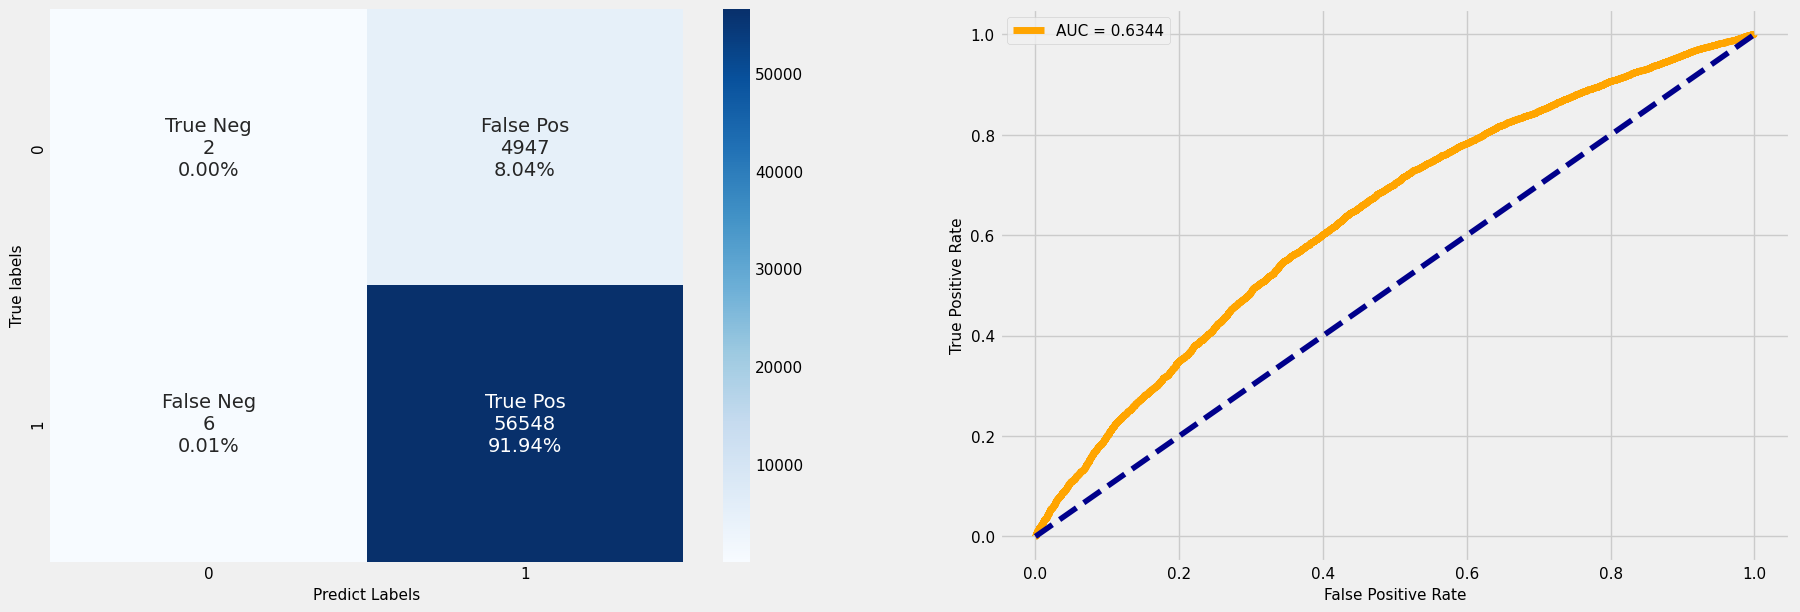

In [37]:
y_pred_proba = lr.predict_proba(X_test)[:,1]
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), y_pred_proba, input_data =df, feature_importances=None, seuil = None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.25) et la Target 1 (0.92). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 8.07 % des individus classés en modalité 0 , à savoir en défaut de paiement de crédit et 92% en modalité 1.

Il est donc intéressant de travailler en Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

### Reéquilibrons les classes en utilisant SMOTE:

In [38]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 226132 
Label 0, Before using SMOTE: 19876 


In [39]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [40]:
print("Label 1, After using SMOTE: {} ".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {} ".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 226132 
Label 0, After using SMOTE: 226132 


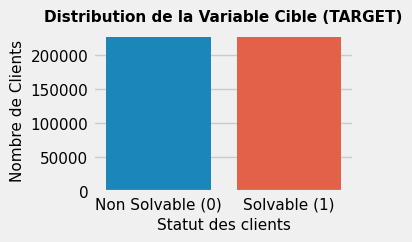

In [41]:
fig = plt.figure(figsize=(3, 2))
sns.countplot(x = y_train_res)

# Ajouter des titres et des étiquettes
plt.title('Distribution de la Variable Cible (TARGET)')
plt.xlabel('Statut des clients')
plt.ylabel('Nombre de Clients')
plt.xticks([0, 1], ['Non Solvable (0)', 'Solvable (1)'])

# Afficher le graphique
plt.show()

### Standardisation des données:

In [42]:
from sklearn import preprocessing

# Créer l'objet StandardScaler
scaler = preprocessing.StandardScaler()

# Appliquer la mise à l'échelle aux ensembles d'entraînement et de test équilibrées
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [43]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res_scaled, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test_scaled)))

AUC : 0.7575
              precision    recall  f1-score   support

         0.0       0.17      0.68      0.27      4949
         1.0       0.96      0.70      0.81     56554

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503

Wall time: 7.36 s


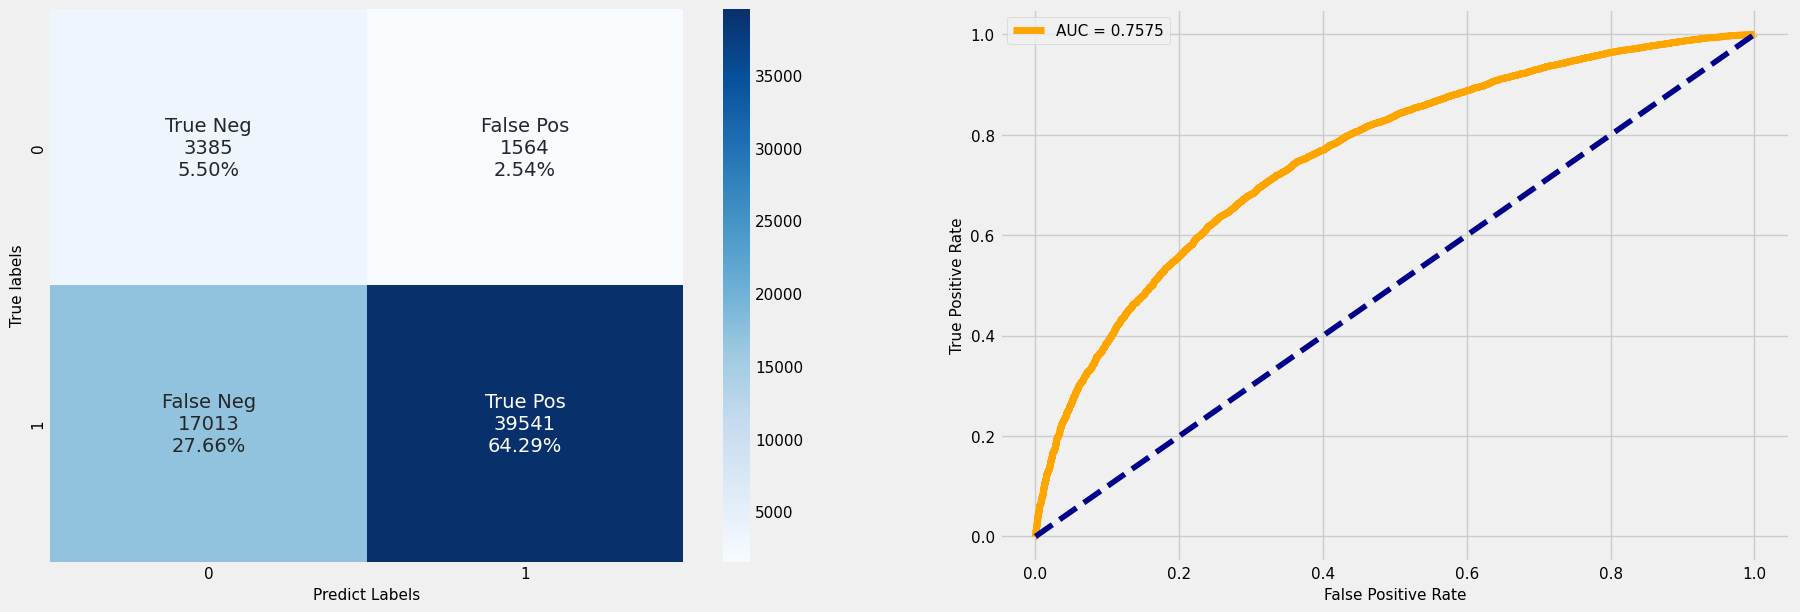

In [44]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test_scaled), lr.predict_proba(X_test_scaled)[:,1],input_data = None,
                  feature_importances=None, seuil =None)

Résultats après SMOTE:

La métrique AUC est passée de 0.6344 à 0.7575, ce qui indique une meilleure capacité de discrimination du modèle.
La précision pour la classe 0 (défaut de paiement) a diminué (de 0.25 à 0.17), mais le rappel (recall) pour cette classe a beaucoup augmenté (de près de 0.00 à 0.68). Cela signifie que le modèle est désormais capable de détecter une proportion beaucoup plus élevée de vrais défauts de paiement, même s'il fait aussi plus d'erreurs en les prédisant.
Bien que l'exactitude globale (accuracy) ait diminué, ce n'est pas nécessairement une mauvaise chose étant donné le déséquilibre initial des classes. Dans des situations comme celle-ci, le rappel pour la classe minoritaire (dans ce cas, les défauts de paiement) est souvent plus important que l'exactitude globale.
Considérations:

L'oversampling avec SMOTE peut augmenter le risque de surapprentissage car il génère des échantillons synthétiques. Cependant, dans ce cas, l'amélioration des performances sur l'ensemble de test suggère que ce n'est probablement pas un problème majeur.
La standardisation des données est une étape importante, surtout pour des modèles comme la régression logistique qui sont sensibles à l'échelle des caractéristiques. Cela pourrait également aider à résoudre le problème de convergence que vous avez rencontré précédemment.

### DummyRegressor: modèle de base

In [45]:
dm = DummyRegressor()
dm.fit(X_train_res_scaled, y_train_res)

baseline_error = np.sqrt(np.mean((dm.predict(X_test_scaled) - y_test) ** 2))
print("Baseline Error (RMSE):", baseline_error)

pred_dm = dm.predict(X_test_scaled)
pred_dm[pred_dm <= 0.5] = 0
pred_dm[pred_dm > 0.5] = 1

print('BASELINE:')
print("AUC score:", roc_auc_score(y_test, pred_dm))
print("FBeta-score:", fbeta_score(y_test, pred_dm, average='micro', beta=0.5))

cm = confusion_matrix(y_test, pred_dm)
print('Confusion matrix\n\n', cm)
print('\nTrue Negatives(TN) =', cm[0, 0])
print('\nFalse Positives(FP) =', cm[0, 1])
print('\nFalse Negatives(FN) =', cm[1, 0])
print('\nTrue Positives(TP) =', cm[1, 1])

Baseline Error (RMSE): 0.5
BASELINE:
AUC score: 0.5
FBeta-score: 0.08046761946571711
Confusion matrix

 [[ 4949     0]
 [56554     0]]

True Negatives(TN) = 4949

False Positives(FP) = 0

False Negatives(FN) = 56554

True Positives(TP) = 0


### 2. Modélisation: Gradient Boosting

In [46]:
#Predictive Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

models = [
          GradientBoostingClassifier(),
          LGBMClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter = 100)
         ]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Dans un premier temps, on utilise les models de bases sur les données de bases pour pouvoir comprer les models et en chosir un afin de l'optimiser par la suite.

In [47]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      }
          
    return output

In [48]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)
base_models

C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 24min 33s


,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.77345,0.919532,0.921616,0.997312,0.957971,8.51938
0,GradientBoostingClassifier,0.765103,0.919776,0.920756,0.998709,0.95815,1094.689845
2,RandomForestClassifier,0.720385,0.919549,0.919588,0.999947,0.958086,359.947563
3,LogisticRegression,0.634362,0.919516,0.919558,0.999947,0.958069,10.046732


LGBMClassifier :

A la plus haute AUC parmi tous les modèles, ce qui signifie qu'il a la meilleure capacité à distinguer entre les deux classes.
Son temps d'exécution est de 8,5 minutes, ce qui est très rapide par rapport aux autres modèles, en particulier le GradientBoostingClassifier.
Il a également la plus haute précision parmi tous les modèles.

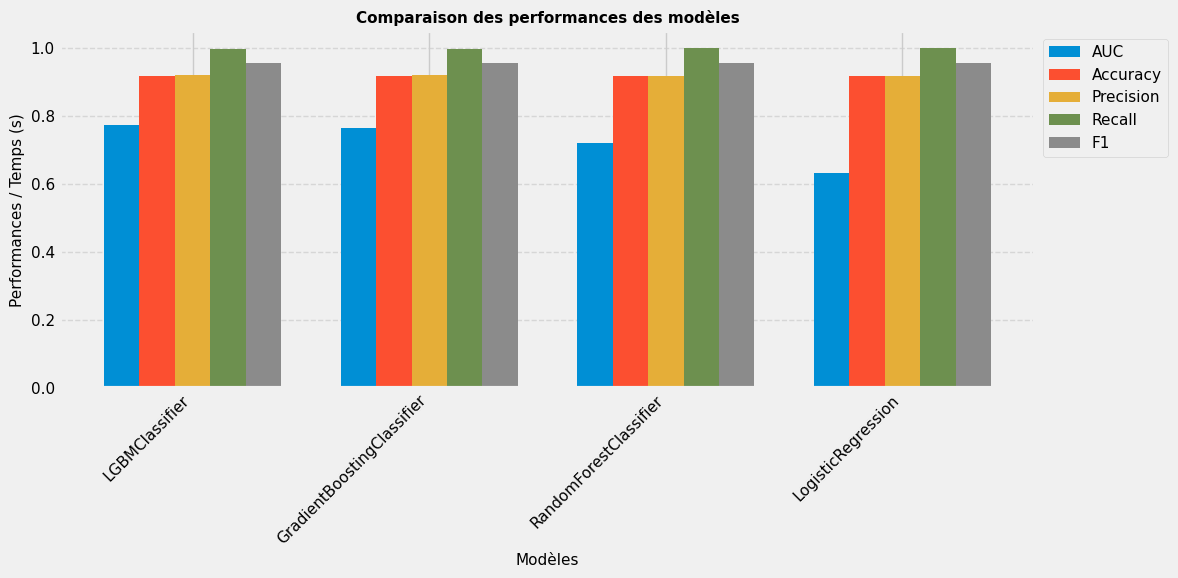

In [51]:
import matplotlib.pyplot as plt

# Noms des modèles pour l'axe des x
model_names = base_models['Model']

# Métriques à comparer, y compris le temps d'exécution
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']

# Valeurs de chaque métrique pour chaque modèle
metric_values = base_models[metrics].values.T

# Créer la figure
plt.figure(figsize=(12, 6))

# Position des barres groupées pour chaque métrique
bar_width = 0.15
positions = range(len(model_names))

# Créer les barres groupées pour chaque métrique
for i, metric in enumerate(metrics[:]):  # Exclure le temps d'exécution pour le moment
    plt.bar([p + i * bar_width for p in positions], metric_values[i], bar_width, label=metric)

# Ajouter une barre pour le temps d'exécution avec une couleur différente (par exemple, rouge)
#plt.bar([p + len(metrics[:-1]) * bar_width for p in positions], metric_values[-1], bar_width, label='Time', color='red')

# Personnalisation de l'axe des x et des étiquettes
plt.xlabel('Modèles')
plt.ylabel('Performances / Temps (s)')
plt.title('Comparaison des performances des modèles')
plt.xticks([p + 2 * bar_width for p in positions], model_names, rotation=45, ha='right')

# Légende
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Afficher la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()

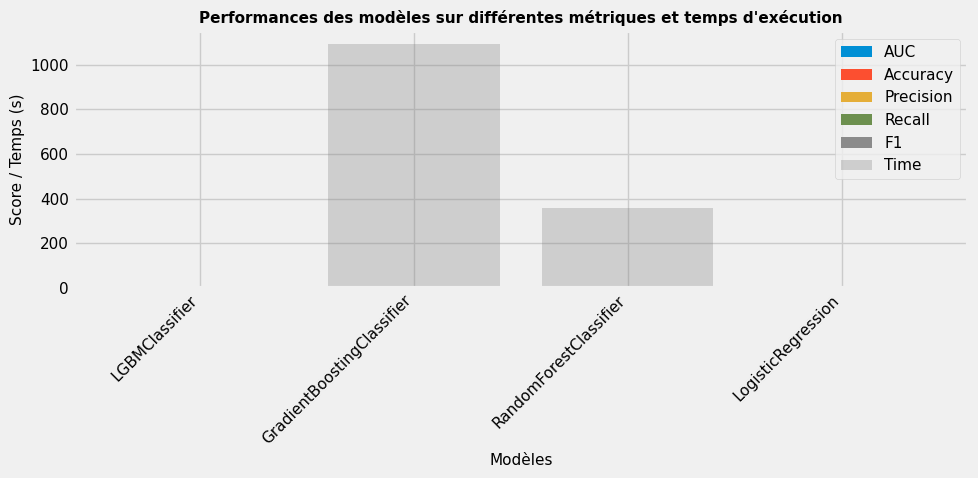

In [52]:
# Ajoutons le temps d'exécution dans le graphique à barres
metrics_with_time = metrics + ['Time']

plt.figure(figsize=(10, 5))
for metric in metrics_with_time:
    if metric == 'Time':
        plt.bar(base_models['Model'], base_models[metric], label=metric, alpha=0.3, color='gray')  # Barre grise pour le temps d'exécution
    else:
        plt.bar(base_models['Model'], base_models[metric], label=metric)

plt.xlabel('Modèles')
plt.ylabel('Score / Temps (s)')
plt.title('Performances des modèles sur différentes métriques et temps d\'exécution')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Résultats:

Le LGBMClassifier obtient la meilleure performance en termes d'AUC, de la précision et du recall, suivi de près par le GradientBoostingClassifier. Cependant, le LGBMClassifier est nettement plus rapide, ce qui peut être un avantage dans notre cas d'utilisation.
Le RandomForestClassifier et la LogisticRegression sont moins performants en termes d'AUC, et bien que la régression logistique soit rapide, elle peut ne pas être suffisante pour notre problème.

Nous allons donc choisir LGBMClassifier comme modèle et nous améliorerons sa performance en équilibrant les données et en optimisant ses hyperparamètres.

## 3. Amélioration du modèle retenu: LGBMClassifier

### **Feature Selection - Recursive Feature Elimination (RFECV)** 
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 278 caractéristiques (features), dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [53]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [54]:
%%time

# Fixer la graine aléatoire pour NumPy
np.random.seed(42)

# Choix du modèle (peut être remplacé par un autre modèle)
model = LGBMClassifier()

cv=StratifiedKFold(5)
# Création de l'objet RFECV avec un estimateur et une méthode de validation croisée
selector = RFECV(estimator=model, step=1, cv=cv)

# Ajuster l'objet RFECV à vos données
selector = selector.fit(X_train_res_scaled, y_train_res)

# Transformer les données en utilisant uniquement les caractéristiques sélectionnées
X_train_selected = selector.transform(X_train_res_scaled)
X_test_selected = selector.transform(X_test_scaled)


Wall time: 16h 27min 19s


In [55]:
model.fit(X_train_selected, y_train_res)
print("Nombre de caractéristiques sélectionnées: {}".format(selector.n_features_))
print("Score du modèle avec les caractéristiques sélectionnées:", model.score(X_test_selected, y_test))
print("Caractéristiques sélectionnées: {}".format(X_train.columns[selector.support_][:20]))

Nombre de caractéristiques sélectionnées: 122
Score du modèle avec les caractéristiques sélectionnées: 0.9199226054013625
Caractéristiques sélectionnées: Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'],
      dtype='object')


In [56]:
# Les caractéristiques sélectionnées sont marquées par un attribut `support_`
selected_features = selector.support_
selected_feature_names = X_test.columns[selected_features]

In [57]:
# Nous pouvons maintenant ajuster notre modèle aux données transformées
model.fit(X_train_selected, y_train_res)

LGBMClassifier()

In [58]:
print("Nombre de caractéristiques sélectionnées:", selector.n_features_)

Nombre de caractéristiques sélectionnées: 122


In [59]:
print("Optimal number of features : %d" % selector.n_features_)
print("Selected Features: %s" % selector.support_[:20])
print("Feature Ranking : %s" % selector.ranking_[:20])

Optimal number of features : 122
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True False  True  True  True]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1  1  1  1 57  1 46  1 32  1  1  1]


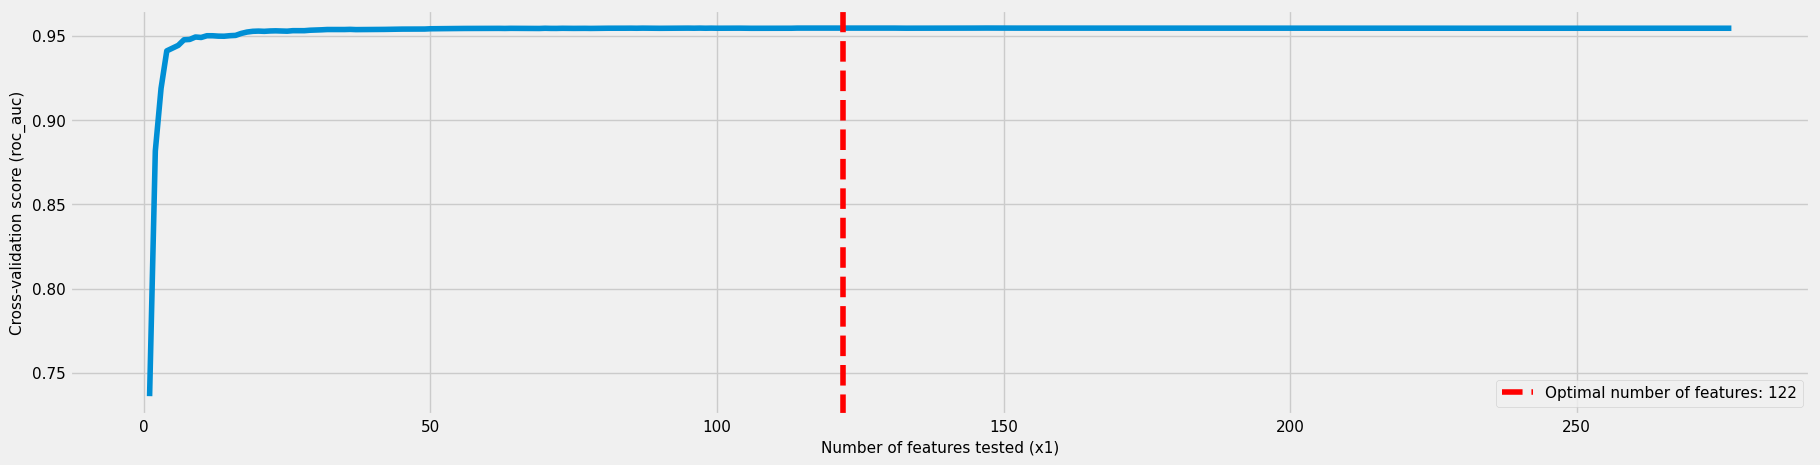

In [60]:
step = 1
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')

# Highlight the optimal number of features with a vertical line
optimal_num_features = selector.n_features_
plt.axvline(x=optimal_num_features, color='red', linestyle='--', label='Optimal number of features: %d' % optimal_num_features)

plt.legend()
plt.show()

In [61]:
# Sauvegardons les données d'entrainement et de test ayant que les features séléctionnées
import joblib

joblib.dump(X_test_selected, path_new_data + 'X_test_selected.joblib')
joblib.dump(y_test, path_new_data + 'y_test_selected.joblib') # y_test n'a pas subi de modification,
                                                                                 # on le renomme tout simplement 

joblib.dump(X_train_selected, path_new_data + 'X_train_selected.joblib')
joblib.dump(y_train_res, path_new_data + 'y_train_selected.joblib')


['C:/Users/aella/Desktop/P7_Abdoullatuf_Maoulida/Data_P7/New_data/y_train_selected.joblib']

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également la figure ci-dessus.

### Création d'un DataFrame avec les caractéristiques sélectionnées

In [62]:
df.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,0.018801,9461.0,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
100003,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,0.003541,16765.0,-1186.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100004,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,0.010032,19046.0,-4260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,0.008019,19005.0,-9833.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,0.028663,19932.0,-4311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# df sotn les données d'origine
# Étape 1: Séparation des caractéristiques des étiquettes
df_train = df   #.drop('TARGET', axis = 1)
y = target['TARGET']

# Étape 2: Utilisons le support de RFECV pour filtrer les colonnes sélectionnées
selected_features = selector.get_support()
df_select = df_train.loc[:, selected_features]

# Étape 3: Vérifions la forme du nouveau DataFrame df_select
print("dimension de df_select:", df_select.shape)

# Étape 4: Fusionner les étiquettes 'TARGET' avec les caractéristiques sélectionnées
# Nous utilisons 'join' car les index sont déjà alignés
df_selected = df_select.join(y, how='inner')

# Étape 5: Vérifier la forme du DataFrame final
print("dimension de df_selected:", df_selected.shape)

dimension de df_select: (307511, 122)
dimension de df_selected: (307511, 123)


Il est nécessaire de sauvegarder le dataset ``df_selected`` de manière à pouvoir le réutiliser facilement.

In [119]:
%%time
compression_opts = dict(method='zip', archive_name='df_selected.csv')
df_selected.to_csv(path_new_data + 'df_selected.zip', index=True, compression=compression_opts)

Wall time: 47.1 s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les best features identifiées (sans les variables "TARGET" et "SK_ID_CURR"). Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement ou pour le tableau de board.

In [129]:
# %%time
# compression_opts = dict(method='zip', archive_name='df_selected_sample.csv')
# df_selected.sample(800).to_csv(path_new_data + 'df_selected_sample.zip', index=True, compression=compression_opts)

Wall time: 283 ms


In [120]:
z = ZipFile(path_new_data + "df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

In [66]:
# Afficher les premières lignes du DataFrame
print("Aperçu des premières lignes du DataFrame :")
X_data.head(5)

Aperçu des premières lignes du DataFrame :


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Transporttype3,FONDKAPREMONT_MODE_regoperaccount,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,EMERGENCYSTATE_MODE_No,TARGET
0,100002,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,0.018801,9461.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,100003,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,0.003541,16765.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,100004,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,0.010032,19046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,100006,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,0.008019,19005.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,0.028663,19932.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [132]:
# from sklearn.model_selection import train_test_split
# seed = 42

# #from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
# df_selected = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

# # Séparation en données de test et d'entrainement (données completes)
# seed = 42
# X_train_select, X_test_select, y_train_select, y_test_select = train_test_split( df_selected.drop(['TARGET'], axis = 1), 
#                                                     df_selected['TARGET'], test_size = 0.2, random_state = seed)

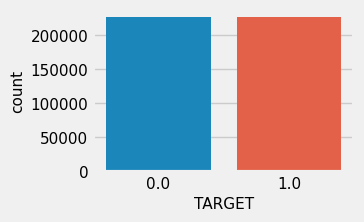

In [67]:
y_train_selected = y_train_res 
fig = plt.figure(figsize=(3,2))
sns.countplot(x = y_train_selected)
plt.show()

In [68]:
X_train_selected.shape, y_train_selected.shape

((452264, 122), (452264,))

In [69]:
X_test_selected = joblib.load(path_new_data + 'X_test_selected.joblib')
y_test_selected = joblib.load(path_new_data + 'y_test_selected.joblib') 

X_train_selected = joblib.load(path_new_data + 'X_train_selected.joblib')
y_train_selected = joblib.load(path_new_data + 'y_train_selected.joblib')

In [70]:
%%time

#Predictive Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

models = [
          GradientBoostingClassifier(),
          LGBMClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter =100)
         ]


name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

C:\Users\aella\anaconda3\envs\monenvprojet\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 32min 47s


In [72]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.770974,0.919923,0.921138,0.998391,0.95821,8.339158
3,LogisticRegression,0.757814,0.698194,0.961987,0.69942,0.809956,9.821953
0,GradientBoostingClassifier,0.736181,0.919451,0.919867,0.99947,0.958018,1488.691565
2,RandomForestClassifier,0.718099,0.919597,0.919619,0.999965,0.958111,460.061337


In [73]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.77345,0.919532,0.921616,0.997312,0.957971,8.51938
0,GradientBoostingClassifier,0.765103,0.919776,0.920756,0.998709,0.95815,1094.689845
2,RandomForestClassifier,0.720385,0.919549,0.919588,0.999947,0.958086,359.947563
3,LogisticRegression,0.634362,0.919516,0.919558,0.999947,0.958069,10.046732


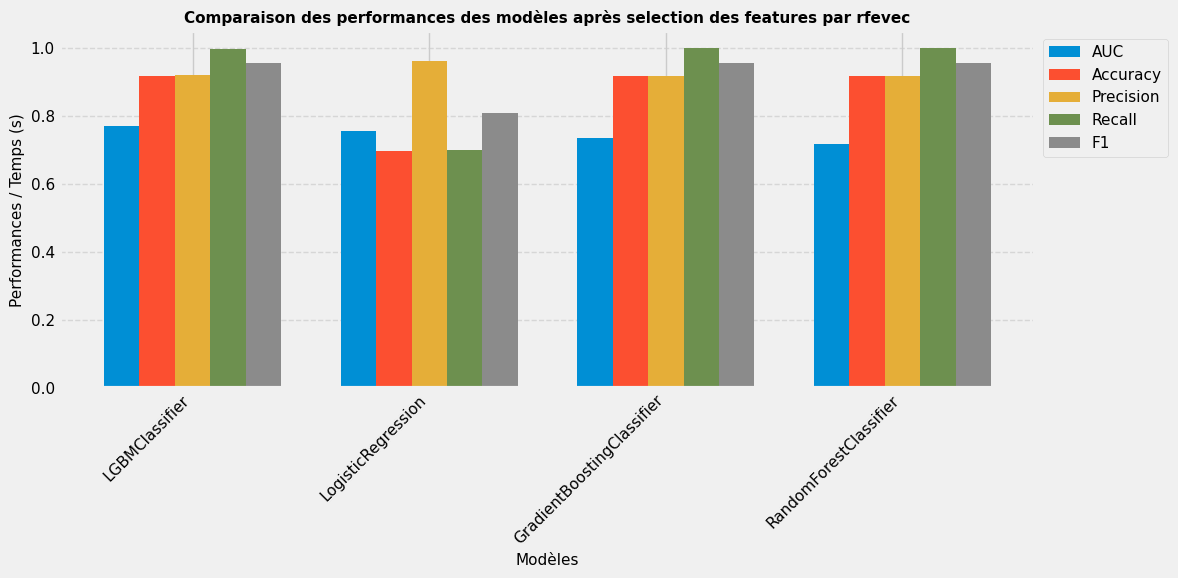

In [74]:
import matplotlib.pyplot as plt

# Noms des modèles pour l'axe des x
model_names = models_rfe['Model']

# Métriques à comparer
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']

# Valeurs de chaque métrique pour chaque modèle
metric_values = models_rfe[metrics].values.T

# Créer la figure
plt.figure(figsize=(12, 6))

# Position des barres groupées pour chaque métrique
bar_width = 0.15
positions = range(len(model_names))

# Créer les barres groupées pour chaque métrique
for i, metric in enumerate(metrics[:]):  
    plt.bar([p + i * bar_width for p in positions], metric_values[i], bar_width, label=metric)

# Ajouter une barre pour le temps d'exécution avec une couleur différente (par exemple, rouge)
#plt.bar([p + len(metrics[:-1]) * bar_width for p in positions], metric_values[-1], bar_width, label='Time', color='red')

# Personnalisation de l'axe des x et des étiquettes
plt.xlabel('Modèles')
plt.ylabel('Performances / Temps (s)')
plt.title('Comparaison des performances des modèles après selection des features par rfevec')
plt.xticks([p + 2 * bar_width for p in positions], model_names, rotation=45, ha='right')

# Légende
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Afficher la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()

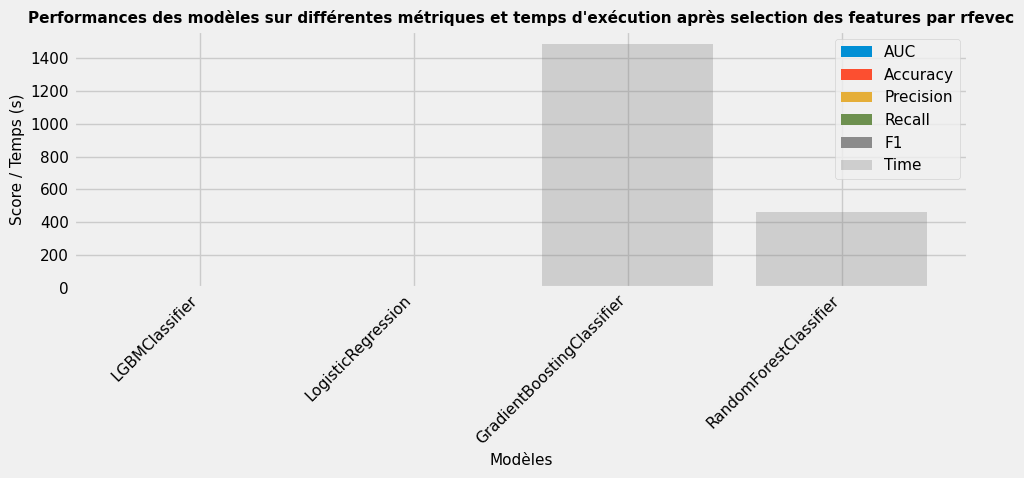

In [75]:
# Ajoutons le temps d'exécution dans le graphique à barres
metrics_with_time = metrics + ['Time']

plt.figure(figsize=(10, 5))
for metric in metrics_with_time:
    if metric == 'Time':
        plt.bar(models_rfe['Model'], models_rfe[metric], label=metric, alpha=0.3, color='gray')  # Barre grise pour le temps d'exécution
    else:
        plt.bar(models_rfe['Model'], models_rfe[metric], label=metric)

plt.xlabel('Modèles')
plt.ylabel('Score / Temps (s)')
plt.title('Performances des modèles sur différentes métriques et temps d\'exécution après selection des features par rfevec')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

LGBMClassifier a toujours le plus grand AUC parmi tous les modèles, ce qui signifie qu'il a la meilleure capacité à distinguer entre les classes positives et négatives. De plus, il est très rapide à entraîner comparé aux autres modèles.

----
Dans la partie suivante on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique 'métier' d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{{Beta}^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
\begin{aligned}{\text{Fscore}}&= (1 + {beta})*{\frac {precision.recall}{{Beta}^2.precision + recall}}\,&=(1+{Beta}^2) . {\frac {tp}{(1+{Beta}^2).tp + {Beta}^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3** si on utilisait le F-Beta score ou une métrique similaire.

### Définition d'un score "métier": 

In [76]:
# On définit une première métrique métier
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import confusion_matrix


def metric_banking_1(y_test, y_pred, cout_fp = 10, cout_fn = 1):
    """
    Métrique bancaire personnalisée pour évaluer les performances du modèle de prédiction de crédit.
    
    Parameters:
    y_test : array-like
        Les vraies étiquettes (0 = négatif, 1 = positif).
    y_pred : array-like
        Les étiquettes prédites par le modèle (0 = négatif, 1 = positif).
    cout_fp : int, optional (default = 10)
        Coût associé à un faux positif (prédire que le client est solvable alors qu'il ne l'est pas).
    cout_fn : int, optional (default = 1)
        Coût associé à un faux négatif (prédire que le client est en défaut alors qu'il est solvable).
    
    Returns:
    metric : float
        La métrique bancaire calculée. Plus la métrique est élevée, meilleure est la performance du modèle.
    """
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculer la sensibilité (ou rappel)
    # C'est le taux de vrais positifs, c'est-à-dire le pourcentage de positifs réels correctement identifiés par le modèle
    sensibilite = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    
    # Calculer la métrique ajustée
    # Cette métrique est conçue pour optimiser les vrais positifs tout en pénalisant les faux positifs et les faux négatifs
    # en fonction des coûts associés (cout_fp et cout_fn)
    metric = sensibilite - cout_fp * cm[0, 1] - cout_fn * cm[1, 0]
    
    # Pire métrique possible :
    pire_metric = 1 - (cout_fp * cm[0, 0] + cout_fn * cm[1, 1])
    
    # Normaliser la métrique :
    normalized_metric = 1 - (metric / pire_metric)
    
    # Retourner la métrique inversée, de manière à ce que des valeurs plus élevées soient meilleures
    return 1 - normalized_metric


#sklearn make_scorer for the banque_score
credit_score_1 = metrics.make_scorer(metric_banking_1, greater_is_better = True)

In [77]:
# tests focntionnels de la métrique
from sklearn.metrics import confusion_matrix
import numpy as np
# Exemple de vraies étiquettes de test et de prédictions (0 = négatif, 1 = positif)
y_test_t = np.array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])
y_pred_t = np.array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

# Testez différentes valeurs pour les coûts FP et FN
cout_fp = 10   # Coût associé aux faux positifs
cout_fn_values = [1, 2, 5]    # Coûts associés aux faux négatifs

for cout_fn in cout_fn_values:
    # Calculer la métrique pour chaque combinaison de coûts
    score = metric_banking_1(y_test_t, y_pred_t, cout_fp, cout_fn)
    print(f"Coût FP = {cout_fp}, Coût FN = {cout_fn}, Métrique = {score}")

Coût FP = 10, Coût FN = 1, Métrique = 0.6121212121212121
Coût FP = 10, Coût FN = 2, Métrique = 0.572972972972973
Coût FP = 10, Coût FN = 5, Métrique = 0.4938775510204081


On choisit donc cout_fp = 10 et cout_fn = 1 pour avoir un meilleur score car on voudrait minimiser cette fonction.

In [43]:
# def metric_banking_2(y_true, y_pred, beta=3) :
#     '''
#     Calcul personnalisé du score F-beta.
    
#     Paramètres :
#     - y_true: tableau, valeurs cibles réelles (vrais labels)
#     - y_pred: tableau, cibles estimées telles que renvoyées par un classificateur
#     - beta: flottant, (valeur par défaut = 3), poids de la précision dans la moyenne harmonique
    
#     Retour :
#     - score: flottant, (1 - Score F-beta) en tant que métrique de performance. Le meilleur score est 0 et le pire est 1.
#     '''
#     tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

#     recall = tp / (tp + fn)
#     precision = tp / (tp + fp)
    
#     fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

#     return 1-fscore

# #sklearn make_scorer for the banque_score
# credit_score_2 = metrics.make_scorer(metric_banking_2, greater_is_better = False)

In [78]:
def metric_banking_2(y_true, y_pred, beta=3):
    '''
    Calcul personnalisé du score F-beta.
    
    Paramètres :
    - y_true: tableau, valeurs cibles réelles (vrais labels)
    - y_pred: tableau, cibles estimées telles que renvoyées par un classificateur
    - beta: flottant, (valeur par défaut = 3), poids de la précision dans la moyenne harmonique
    
    Retour :
    - score: flottant, (1 - Score F-beta) en tant que métrique de performance. Le meilleur score est 0 et le pire est 1.
    '''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    # Éviter une division par zéro
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
        
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    # Calculer le F-beta score
    if (beta**2 * precision + recall) == 0:
        fscore = 0
    else:
        fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    return 1 - fscore

# sklearn make_scorer for the banque_score
credit_score_2 = metrics.make_scorer(metric_banking_2, greater_is_better = False)

In [79]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score moins importants.

### LgbmClassifier avant l'optimisation des hyperparamètres:

In [80]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_res_scaled, y_train_res)

LGBMClassifier()

In [81]:
cost_false(lgbm, y_test, X_test_scaled)

False Pos: 7.89%
False Neg: 0.14%


(0.0789392387363218, 0.001414565143163748)

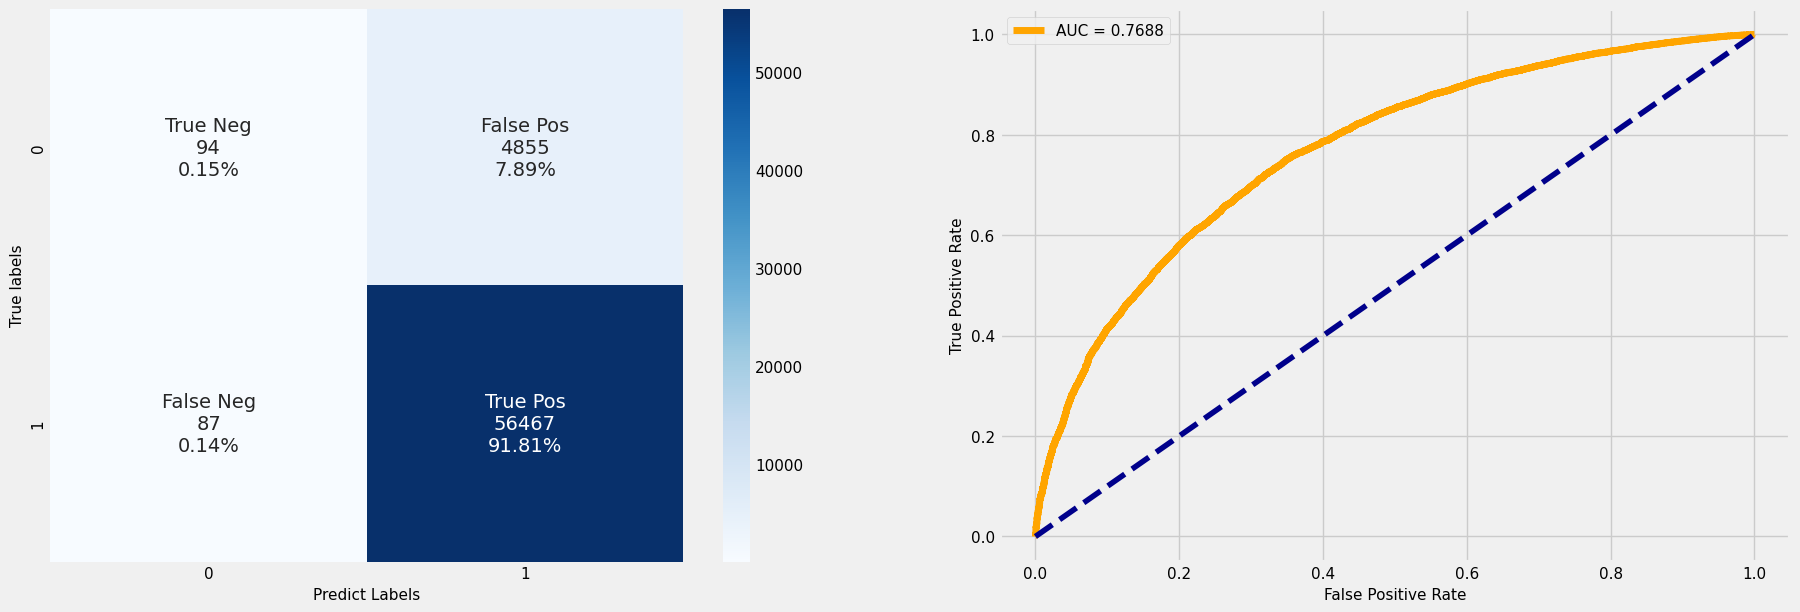

In [82]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_scaled), lgbm.predict_proba(X_test_scaled)[:,1],
                  input_data = None, feature_importances=None, seuil = None)

### 4. Optimisation:

##### - Optimisation par RandomizedSearch:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03],
    'max_depth': [3, 4, 5, 6, 7],
    'num_leaves': [10, 30, 50, 70, 90, 100],
    'subsample': [0.60, 0.70, 0.80, 0.85, 0.90, 0.95],
    'colsample_bytree': [0.60, 0.70, 0.80, 0.85, 0.90, 0.95],
    'reg_lambda': [1, 5, 10, 15, 20]
}


clf = LGBMClassifier(boosting_type='gbdt', seed=42, n_jobs=-1, objective='binary')

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist,
    n_iter=100, 
    scoring='accuracy', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train_selected, y_train_selected)

In [ ]:
print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleure précision : {random_search.best_score_:.4f}")

### - **Hyperparameters tunning - Hyperopt et credit score ("score métier")**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié. On explorera Grid Search aussi.


In [88]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

#### 1ere mise en place de recherche des meilleurs hyperparamètres:

In [89]:
import joblib
X_train_selected = joblib.load(path_new_data + "X_train_selected.joblib")
y_train_selected = joblib.load(path_new_data + "y_train_selected.joblib")

X_test_selected = joblib.load(path_new_data + 'X_test_selected.joblib')
y_test_selected = joblib.load(path_new_data + 'y_test_selected.joblib')


z = ZipFile(path_new_data + "df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

In [90]:

# Définir l'espace des hyperparamètres à explorer
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 100, 10),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20),
    'seed': 2023,    # Seed fixe pour la reproductibilité
    'boosting_type': 'gbdt'    # Type d'algorithme boosting
}

# Définir la fonction objectif à minimiser

def objective_1(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {        
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'random_state': params['seed'], # Renommons 'seed' en 'random_state'
        'boosting_type': params['boosting_type']
        
        }
    
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    
    
    # Cross-validation pour estimer les performances du modèle
    cv_scores = cross_val_score(model, X_train_selected, y_train_selected, cv=cv, 
                             
                             scoring=credit_score_1
                             
                            )
    
    avg_score = cv_scores.mean()
    return {'loss': 1 - avg_score, 'status': STATUS_OK} 

In [91]:
# Créer une instance de Trials pour enregistrer les résultats de chaque essai
trials = Trials()

# Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
best = fmin(fn=objective_1, space=space, algo=tpe.suggest, max_evals=100,  # Nombre d'essais d'hyperparamètres à effectuer
    trials=trials
)

100%|█████████████████████████████████████████████| 100/100 [2:01:50<00:00, 73.11s/trial, best loss: 0.650083995455592]


In [92]:
# Afficher les meilleurs hyperparamètres trouvés
best_params = space_eval(space, best)
print("Meilleurs hyperparamètres trouvés :")
print(best_params)

Meilleurs hyperparamètres trouvés :
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8287994173682373, 'learning_rate': 0.0012057361893816026, 'max_depth': 3.0, 'n_estimators': 200.0, 'num_leaves': 40.0, 'reg_lambda': 1.7523741383711169, 'seed': 2023, 'subsample': 0.7919653667947019}


In [93]:
# Créer le modèle avec les meilleurs hyperparamètres trouvés
best_lgbm = LGBMClassifier( #Fit a new model based on the best parameters
                            n_estimators=int(best['n_estimators']), 
                            learning_rate= best['learning_rate'],
                            max_depth= int(best['max_depth']),
                            num_leaves = int(best['num_leaves']),
                            subsample= best['subsample'],
                            colsample_bytree= best['colsample_bytree'],
                            reg_lambda= best['reg_lambda'],
                            boosting_type = 'gbdt',
                            objective = 'binary',
                            random_state = 42
                            )

In [94]:
# Entraîner le modèle sur les données d'entraînement
best_lgbm.fit(X_train_selected, y_train_selected)

LGBMClassifier(colsample_bytree=0.8287994173682373,
               learning_rate=0.0012057361893816026, max_depth=3,
               n_estimators=200, num_leaves=40, objective='binary',
               random_state=42, reg_lambda=1.7523741383711169,
               subsample=0.7919653667947019)

In [108]:
test_score = metric_banking_1(y_test_selected, y_pred_test)
train_score = metric_banking_1(y_train_selected, y_pred_train)

print("Score métier sur les données de test :", test_score)
print("Score métier sur les données d'entraînement :", train_score)

Score métier sur les données de test : 0.7824290943065335
Score métier sur les données d'entraînement : 0.3249024643504632


#### Evaluation sur les données de test:

In [95]:
# Évaluer le modèle sur les données de test
print("Score du modèle best_lgbm 1 sur les données de test :", best_lgbm.score(X_test_selected, y_test_selected))

Score du modèle best_lgbm 1 sur les données de test : 0.8795343316586183


#### Evaluation sur les données d'entrainement:

In [96]:
# Évaluer le modèle sur les données d'entrainement
print("Score du modèle best_lgbm 1 sur les données d'entrainement :", best_lgbm.score(X_train_selected, y_train_selected))

Score du modèle best_lgbm 1 sur les données d'entrainement : 0.8400071639573347


In [97]:
#Sauvegardons les meilleurs paramètres:
joblib.dump(best_params, path_new_data + 'best_lgbm_params.joblib')

['C:/Users/aella/Desktop/P7_Abdoullatuf_Maoulida/Data_P7/New_data/best_lgbm_params.joblib']

In [98]:
from sklearn.metrics import classification_report

# Faire des prédictions sur les données de test
y_pred_selected = best_lgbm.predict(X_test_selected)

# Calculer et afficher les métriques de classification
print(classification_report(y_test_selected, y_pred_selected))

# Afficher les coûts pour les faux positifs et faux négatifs si vous le souhaitez
cost_false(best_lgbm, y_test_selected, X_test_selected)

              precision    recall  f1-score   support

         0.0       0.16      0.12      0.14      4949
         1.0       0.92      0.95      0.94     56554

    accuracy                           0.88     61503
   macro avg       0.54      0.53      0.54     61503
weighted avg       0.86      0.88      0.87     61503

False Pos: 7.07%
False Neg: 4.98%


(0.07071199778872575, 0.04975367055265597)

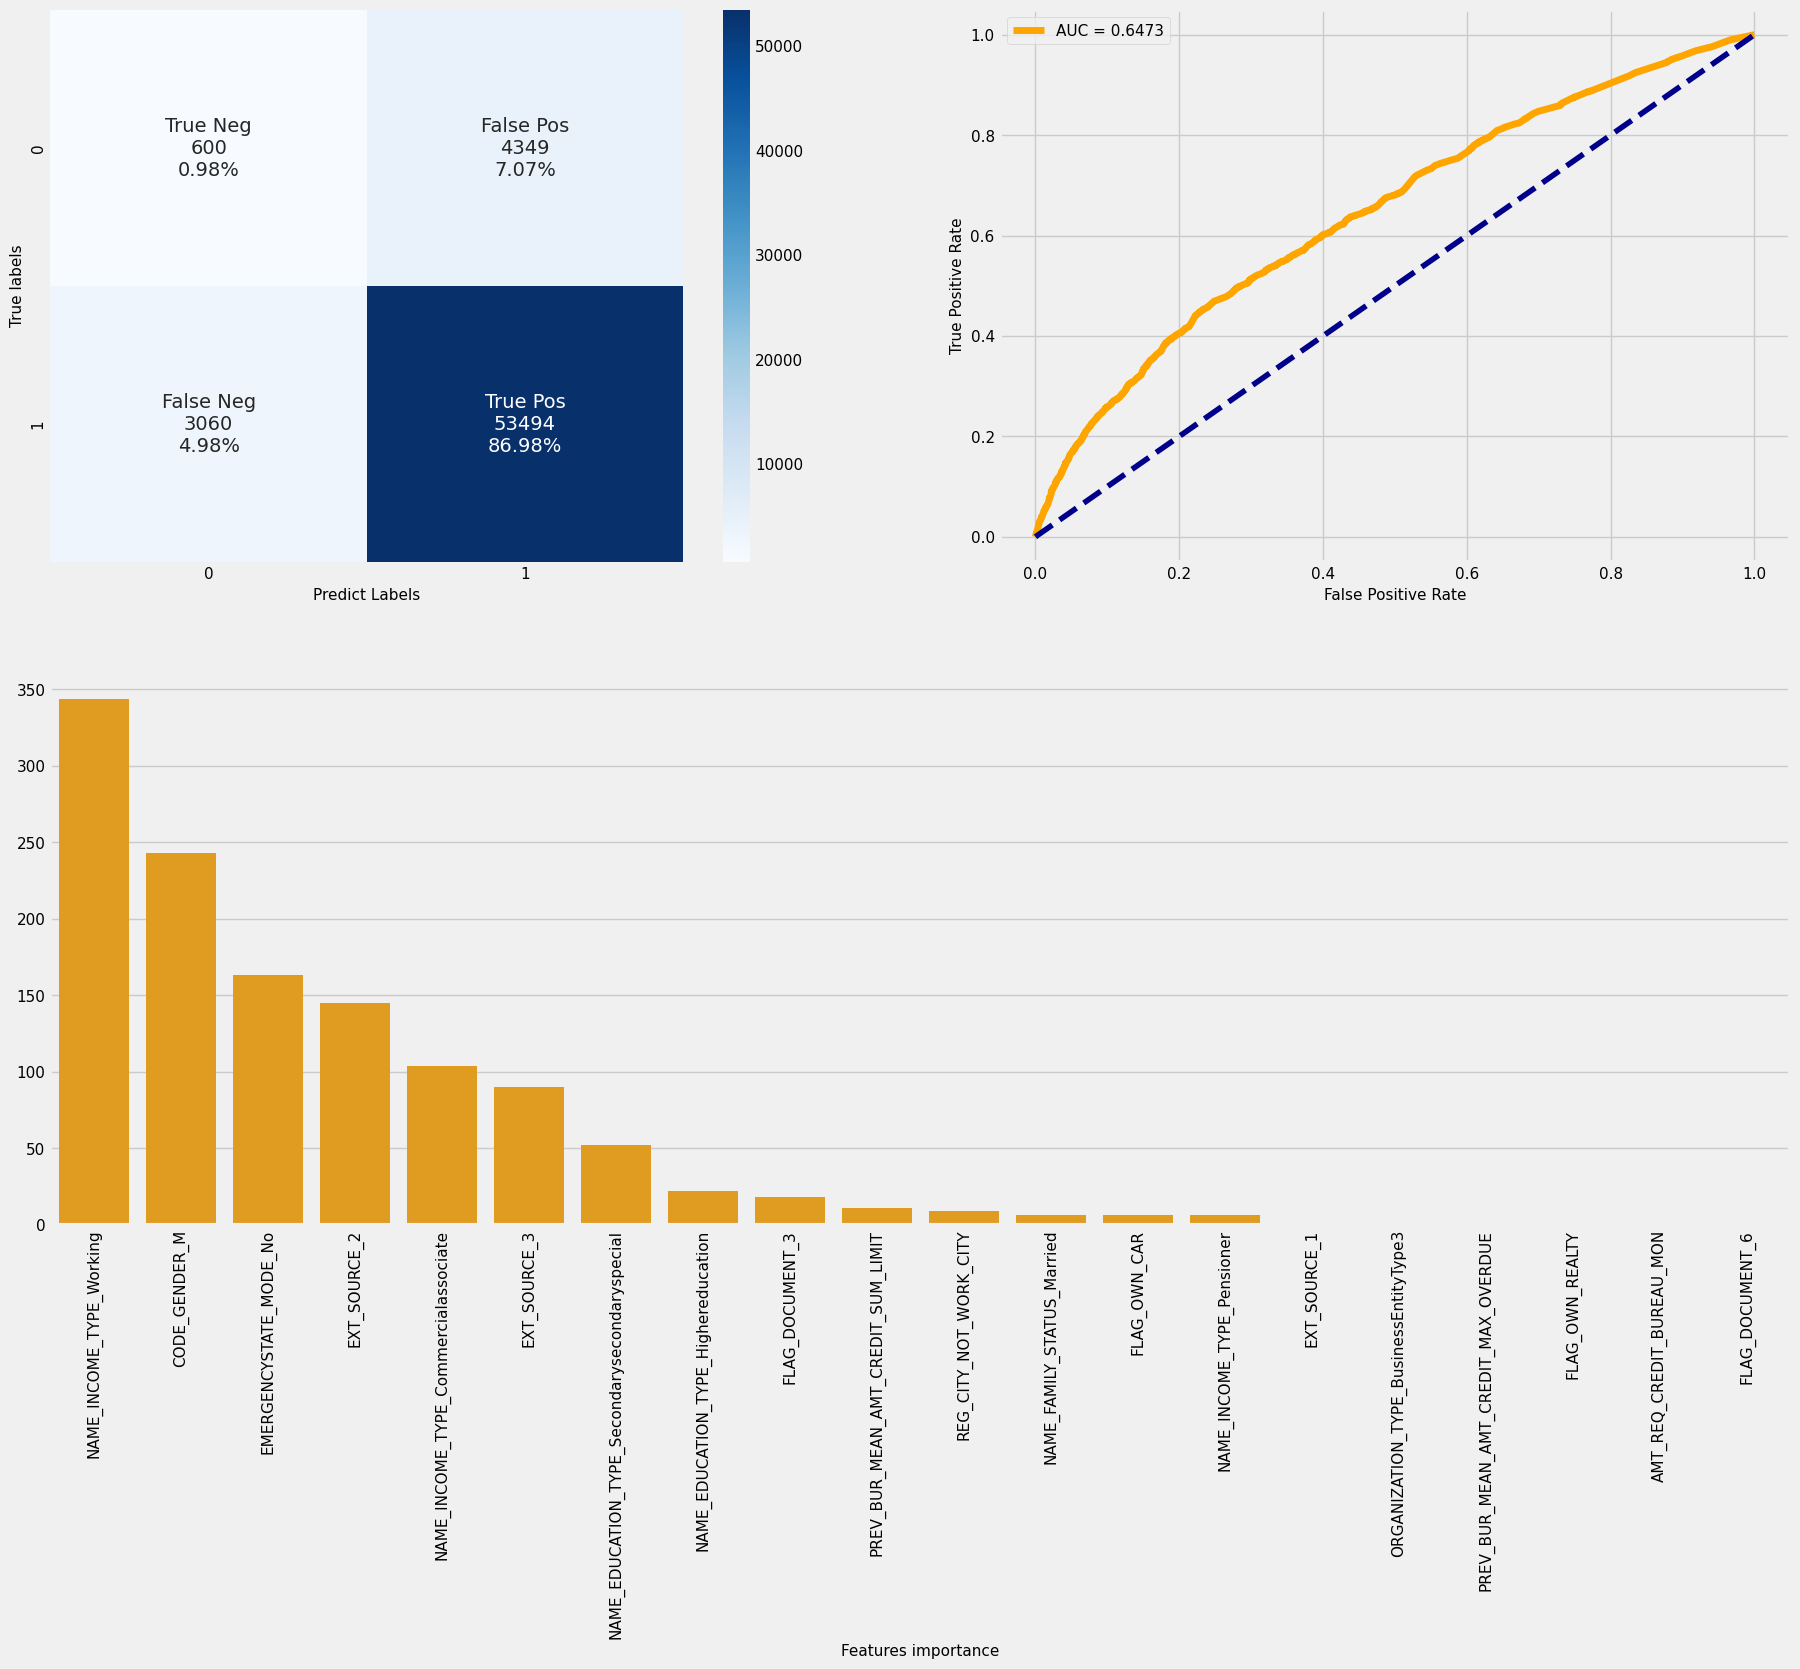

In [99]:
cf_matrix_roc_auc(best_lgbm, y_test_selected, best_lgbm.predict(X_test_selected), best_lgbm.predict_proba(X_test_selected)[:,1],
                  input_data = X_data, feature_importances=True, seuil = None)

In [100]:
roc_auc = roc_auc_score(y_test_selected, best_lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.647339


In [102]:
joblib.dump(best_lgbm, 'best_lgbm.joblib')

['best_lgbm.joblib']

### 2e métrique:

In [139]:
# Définir l'espace des hyperparamètres à explorer
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50), # Réduire le nombre max d'estimateurs
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 6, 1),  # Limiter la profondeur à 6 au maximum
    'num_leaves': hp.quniform('num_leaves', 10, 50, 5),  # Limiter le nombre de feuilles
    'subsample': hp.uniform('subsample', 0.70, 0.95),  # Augmenter le subsampling minimum
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 3, 25),  # Augmenter la régularisation
    'seed': 42,  # Seed fixe pour la reproductibilité
    'boosting_type': 'gbdt'  # Type d'algorithme boosting
}



In [103]:

# Définir la fonction objectif à minimiser
def objective_2(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'boosting_type': params['boosting_type'],
        'random_state': 42
    }
    
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    
    
    # Cross-validation pour estimer les performances du modèle
    scores = cross_val_score(model, X_train_selected, y_train_selected, cv=cv, 
                             
                             scoring=credit_score_2
                             
                            )
    
    # Calcul de la moyenne des scores obtenus
    avg_score = scores.mean()
    
    return {'loss': - avg_score, 'status': 'ok'}  

# Créer une instance de Trials pour enregistrer les résultats de chaque essai
trials = Trials()

# Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
best_2 = fmin(fn=objective_2, space=space, algo=tpe.suggest, max_evals=100,  # Nombre d'essais d'hyperparamètres à effectuer
    trials=trials
)

100%|██████████████████████████████████████████| 100/100 [11:33:20<00:00, 416.01s/trial, best loss: 0.5015452817420262]


In [104]:
# Afficher les meilleurs hyperparamètres trouvés
best_params_2 = space_eval(space, best_2)
print("Meilleurs hyperparamètres trouvés :")
print(best_params_2)

Meilleurs hyperparamètres trouvés :
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9180622024811349, 'learning_rate': 0.028292972024693355, 'max_depth': 7.0, 'n_estimators': 600.0, 'num_leaves': 70.0, 'reg_lambda': 8.011148669086213, 'seed': 2023, 'subsample': 0.697233034914636}


In [105]:
%%time
# Créer le modèle avec les meilleurs hyperparamètres trouvés
best_lgbm_2 = LGBMClassifier( #Fit a new model based on the best parameters
                            n_estimators=int(best_2['n_estimators']), 
                            learning_rate= best_2['learning_rate'],
                            max_depth= int(best_2['max_depth']),
                            num_leaves = int(best_2['num_leaves']),
                            subsample= best_2['subsample'],
                            colsample_bytree= best_2['colsample_bytree'],
                            reg_lambda= best_2['reg_lambda'],
                            boosting_type = 'gbdt',
                            objective = 'binary',
                            random_state = 2023
                            )
best_lgbm_2.fit(X_train_selected, y_train_selected)

Wall time: 37.4 s


LGBMClassifier(colsample_bytree=0.9180622024811349,
               learning_rate=0.028292972024693355, max_depth=7,
               n_estimators=600, num_leaves=70, objective='binary',
               random_state=2023, reg_lambda=8.011148669086213,
               subsample=0.697233034914636)

In [106]:
# Évaluer le modèle sur les données de test
print("Score du modèle best_lgbm 2 sur les données de test :", best_lgbm_2.score(X_test_selected, y_test_selected))

Score du modèle best_lgbm 2 sur les données de test : 0.9199388647708242


In [109]:
#from sklearn.metrics import classification_report

# Faire des prédictions sur les données de test
y_pred_selected_2 = best_lgbm_2.predict(X_test_selected)

# Calculer et afficher les métriques de classification
print(classification_report(y_test_selected, y_pred_selected_2))

# Afficher les coûts pour les faux positifs et faux négatifs si vous le souhaitez
cost_false(best_lgbm_2, y_test_selected, X_test_selected)

              precision    recall  f1-score   support

         0.0       0.55      0.03      0.05      4949
         1.0       0.92      1.00      0.96     56554

    accuracy                           0.92     61503
   macro avg       0.73      0.51      0.51     61503
weighted avg       0.89      0.92      0.89     61503

False Pos: 7.81%
False Neg: 0.19%


(0.07814252963270084, 0.0019186055964749687)

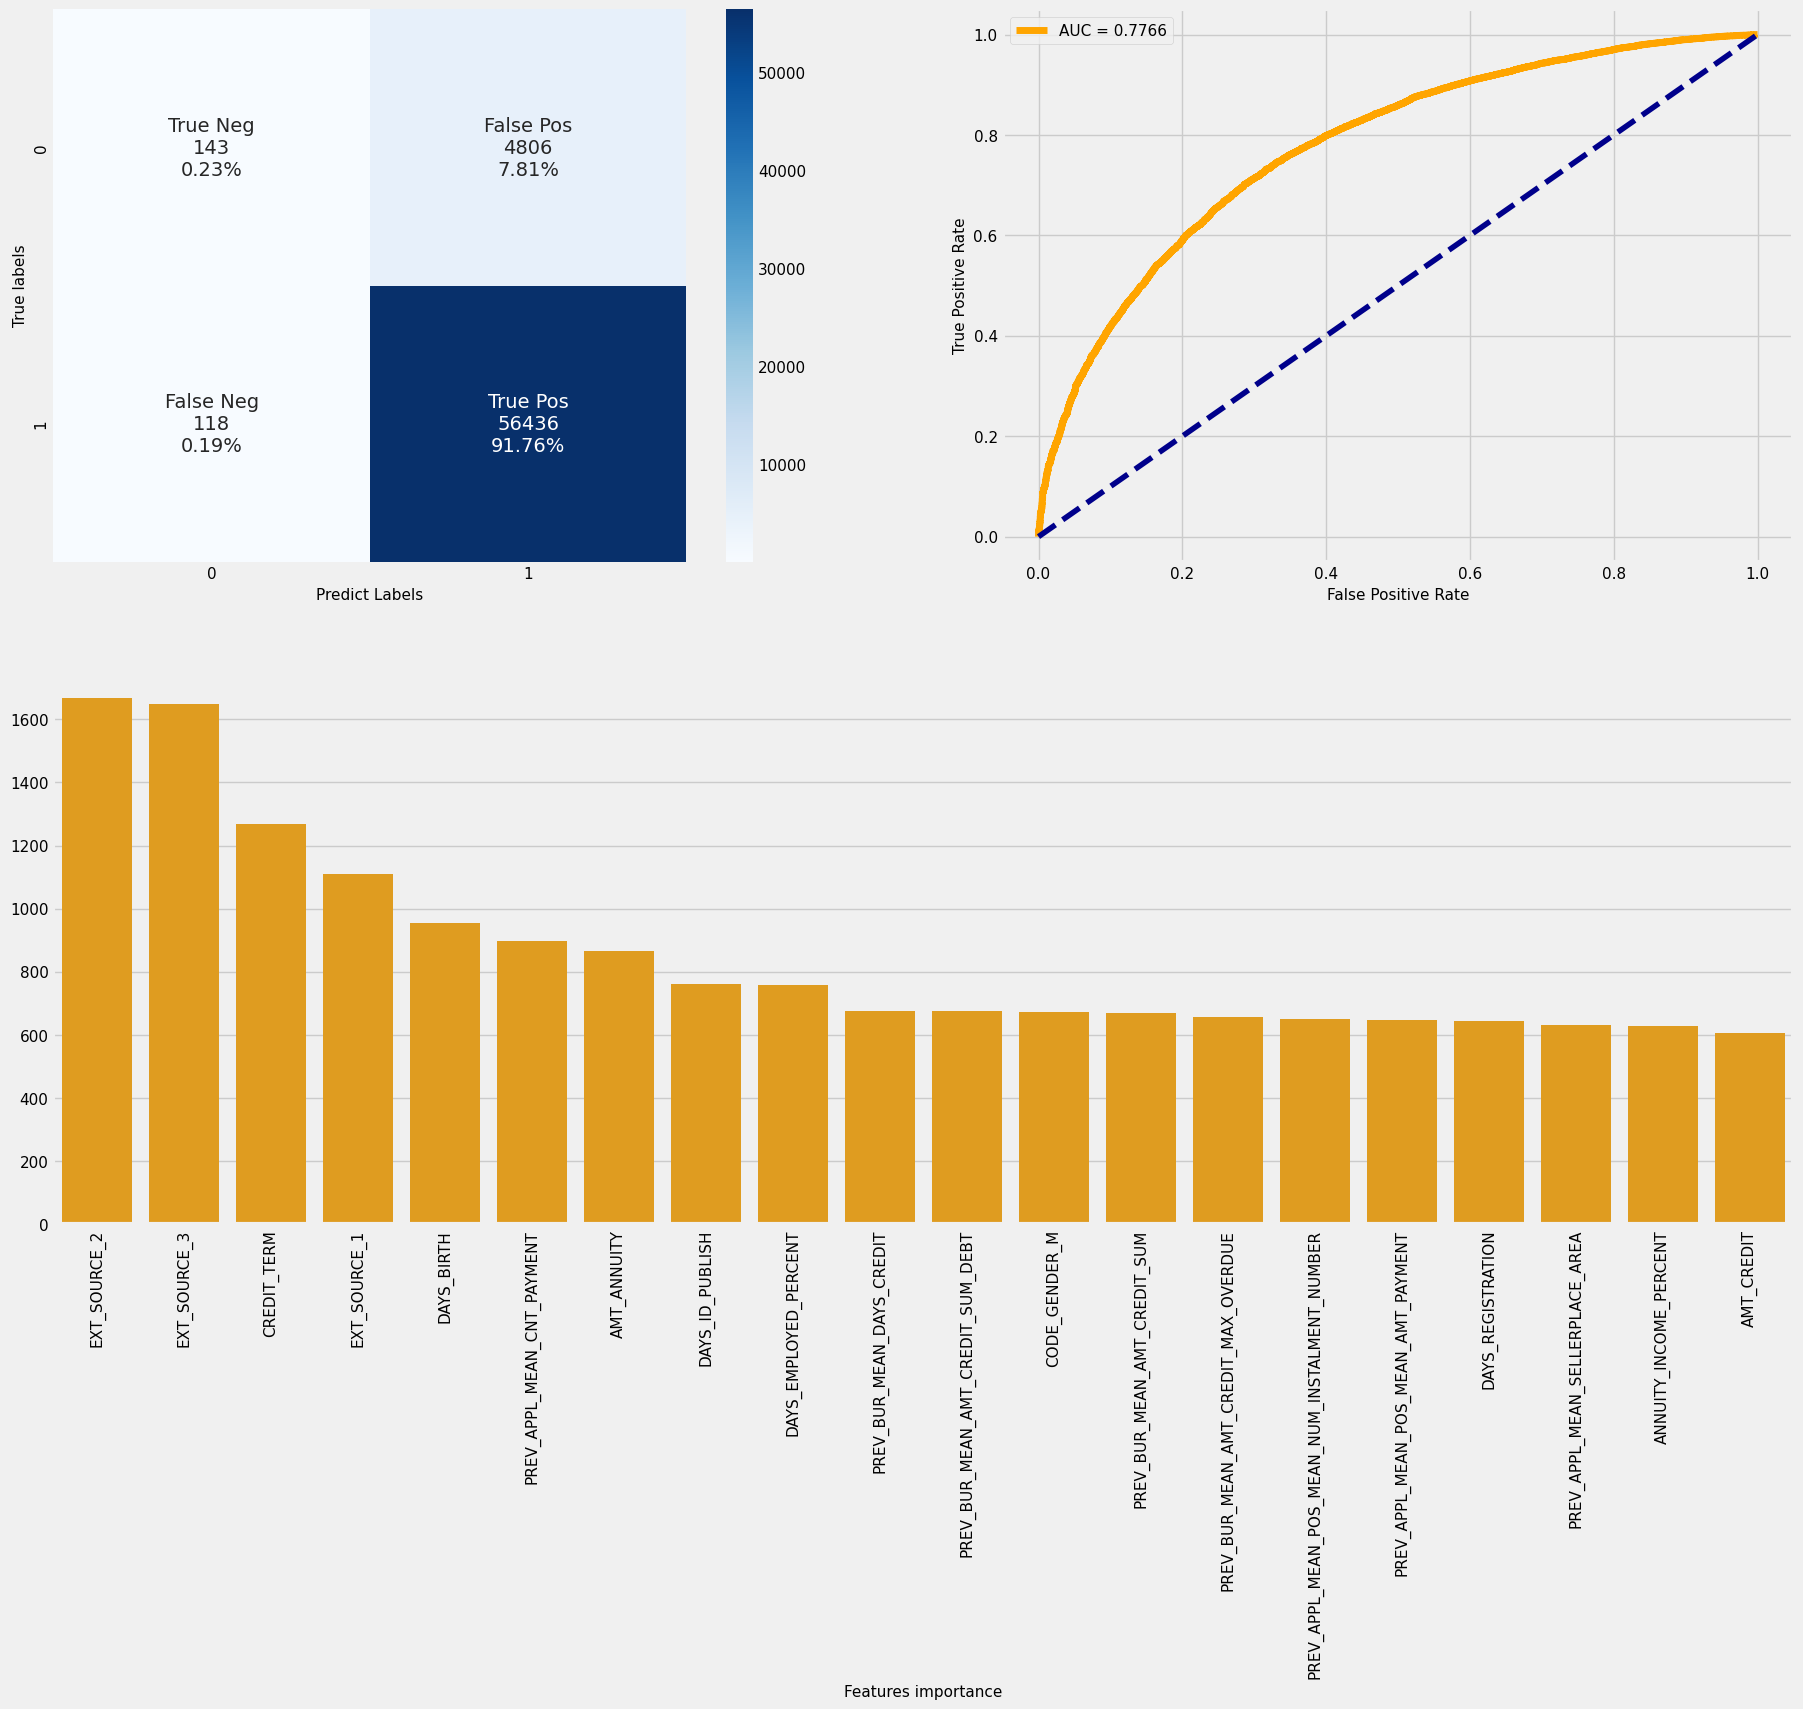

In [110]:
cf_matrix_roc_auc(best_lgbm_2, y_test_selected, y_pred_selected_2, best_lgbm_2.predict_proba(X_test_selected)[:,1],
                  input_data = X_data, feature_importances=True, seuil = None)

In [111]:
test_score = metric_banking_2(y_test_selected, y_pred_test)
train_score = metric_banking_2(y_train_selected, y_pred_train)

print("Score métier sur les données de test :", test_score)
print("Score métier sur les données d'entraînement :", train_score)

Score métier sur les données de test : 0.9877677337280278
Score métier sur les données d'entraînement : 0.5375555630902666


In [112]:
roc_auc = roc_auc_score(y_test_selected, best_lgbm_2.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.776590


In [114]:
roc_auc_train =roc_auc_score(y_train_selected, best_lgbm_2.predict_proba(X_train_selected)[:,1])
print('AUC sur les données d\'entrainement : %0.6f' %roc_auc_train)

AUC sur les données d'entrainement : 0.986345


In [192]:
joblib.dump(best_lgbm_2, 'best_lgbm_2.joblib')

['best_lgbm_2.joblib']

In [115]:
0.986345 - 0.776590

0.20975500000000002

### 3e métrique:

In [116]:
def custom_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 0.9 * fp / (tn + fp) + 0.1 * fn / (tp + fn)

credit_score_3 = make_scorer(custom_metric, greater_is_better=False)

In [117]:
# Définir l'espace des hyperparamètres à explorer
# même espace que pour les deux autres métrique

# Définir la fonction objectif à minimiser
def objective_3(params):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {        
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'random_state': params['seed'], # Renommons 'seed' en 'random_state'
        'boosting_type': params['boosting_type']     
        }
    
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    
    
    # Cross-validation pour estimer les performances du modèle
    scores = cross_val_score(model, X_train_selected, y_train_selected, cv=cv, 
                             
                             scoring=credit_score_3
                             
                            )
    
    # Calcul de la moyenne des scores obtenus
    avg_score = scores.mean()
    
    return {'loss': - avg_score, 'status': 'ok'}  

# Créer une instance de Trials pour enregistrer les résultats de chaque essai
trials = Trials()

# Utiliser l'algorithme TPE (Tree-structured Parzen Estimator) pour l'optimisation
best_3 = fmin(fn=objective_3, space=space, algo=tpe.suggest, max_evals=100,  # Nombre d'essais d'hyperparamètres à effectuer
    trials=trials
)

100%|██████████████████████████████████████████| 100/100 [3:26:43<00:00, 124.03s/trial, best loss: 0.07961172391473474]


In [121]:
# Afficher les meilleurs hyperparamètres trouvés
best_params_3 = space_eval(space, best_3)
print("Meilleurs hyperparamètres trouvés :")
print(best_params_3)

Meilleurs hyperparamètres trouvés :
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9480348771370825, 'learning_rate': 0.027701321109592017, 'max_depth': 7.0, 'n_estimators': 600.0, 'num_leaves': 90.0, 'reg_lambda': 8.311662848490474, 'seed': 2023, 'subsample': 0.8265375416805769}


In [122]:
%%time
best_lgbm_3 = LGBMClassifier( #Fit a new model based on the best parameters
                            n_estimators=int(best_3['n_estimators']), 
                            learning_rate= best_3['learning_rate'],
                            max_depth= int(best_3['max_depth']),
                            num_leaves = int(best_3['num_leaves']),
                            subsample= best_3['subsample'],
                            colsample_bytree= best_3['colsample_bytree'],
                            reg_lambda= best_3['reg_lambda'],
                            boosting_type = 'gbdt',
                            objective = 'binary',
                            random_state = 2023
                            )

best_lgbm_3.fit(X_train_selected, y_train_selected)

Wall time: 35.8 s


LGBMClassifier(colsample_bytree=0.9480348771370825,
               learning_rate=0.027701321109592017, max_depth=7,
               n_estimators=600, num_leaves=90, objective='binary',
               random_state=2023, reg_lambda=8.311662848490474,
               subsample=0.8265375416805769)

In [123]:
# Évaluer le modèle sur les données de test
print("Score du modèle best_lgbm 3 sur les données de test :", best_lgbm_3.score(X_test_selected, y_test_selected))

Score du modèle best_lgbm 3 sur les données de test : 0.9196461961205145


In [124]:
# Évaluer le modèle sur les données de test
print("Score du modèle best_lgbm 3 sur les données d'entrainement :", best_lgbm_3.score(X_train_selected, y_train_selected))

Score du modèle best_lgbm 3 sur les données d'entrainement : 0.9582345709585551


In [125]:
#from sklearn.metrics import classification_report

# Faire des prédictions sur les données de test
y_pred_selected_3 = best_lgbm_3.predict(X_test_selected)

# Calculer et afficher les métriques de classification
print(classification_report(y_test_selected, y_pred_selected_3))

# Afficher les coûts pour les faux positifs et faux négatifs si vous le souhaitez
cost_false(best_lgbm_3, y_test_selected, X_test_selected)

              precision    recall  f1-score   support

         0.0       0.51      0.03      0.05      4949
         1.0       0.92      1.00      0.96     56554

    accuracy                           0.92     61503
   macro avg       0.72      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503

False Pos: 7.84%
False Neg: 0.20%


(0.07838642017462563, 0.0019673837048599257)

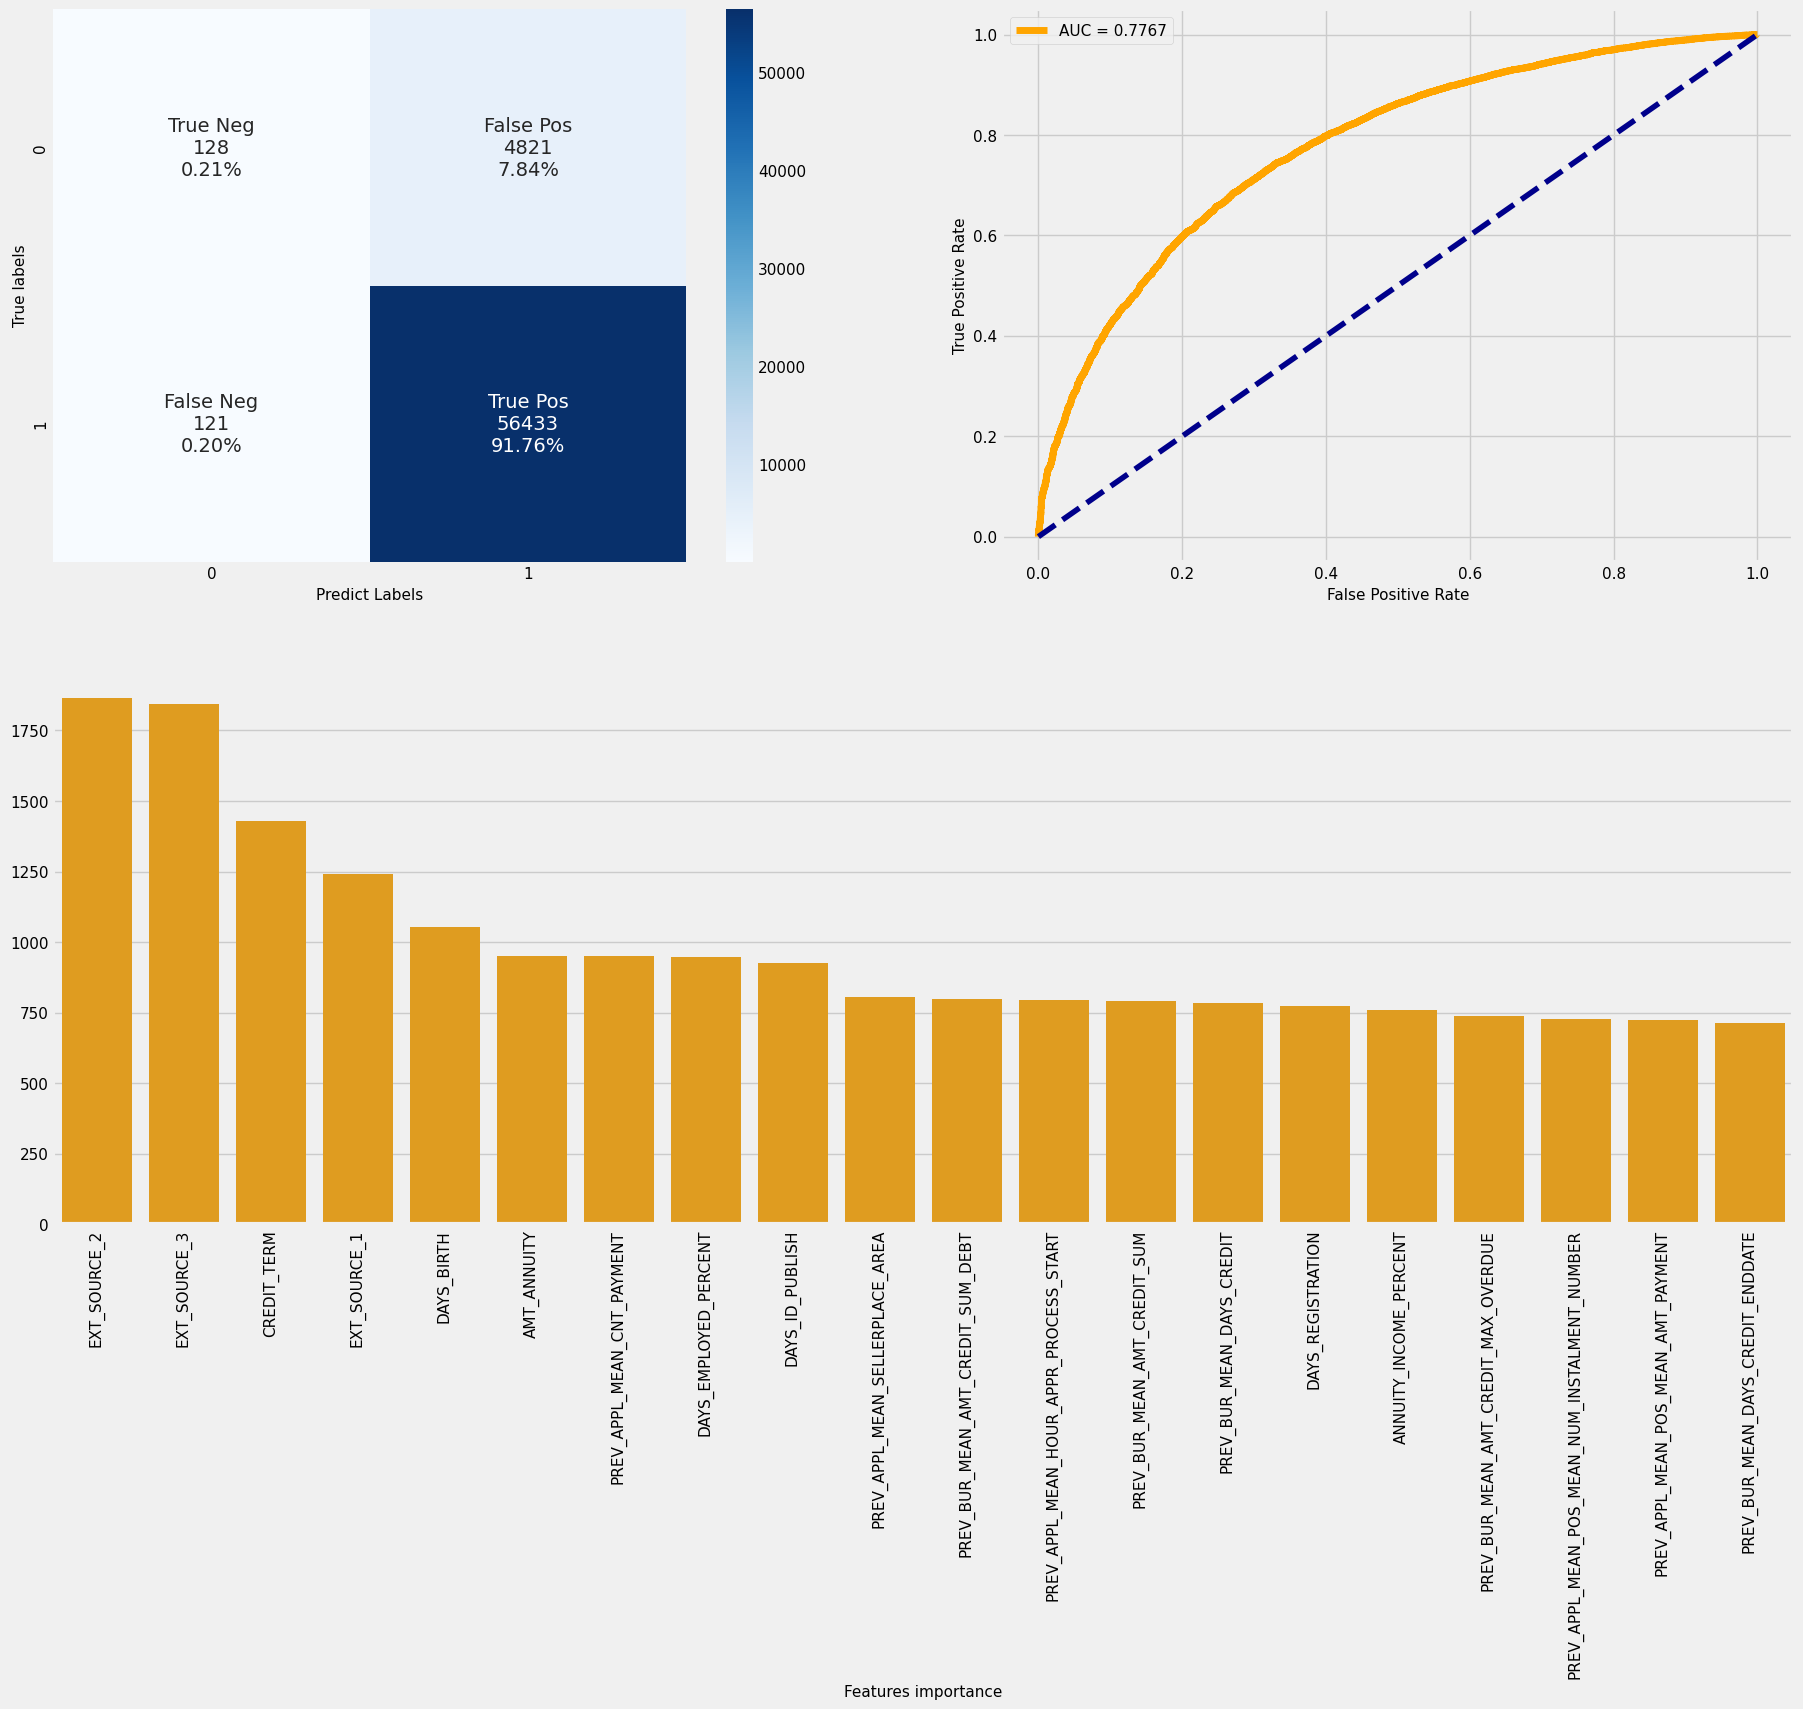

In [126]:
cf_matrix_roc_auc(best_lgbm_3, y_test_selected, y_pred_selected_3, best_lgbm_3.predict_proba(X_test_selected)[:,1],
                  input_data = X_data, feature_importances=True, seuil = None)

In [127]:
test_score = custom_metric(y_test_selected, y_pred_test)
train_score = custom_metric(y_train_selected, y_pred_train)

print("Score métier sur les données de test :", test_score)
print("Score métier sur les données d'entraînement :", train_score)

Score métier sur les données de test : 0.796297805748207
Score métier sur les données d'entraînement : 0.24333353970247468


On retiendra le 3e model (`best_lgbm_3`) car celui ci a le score le plus élevé (AUC = 0.78 environ) et pénalise mieux les faux négatifs (0.20%) et les faux positifs (8%).

In [128]:
joblib.dump(best_lgbm_3, 'best_model_3.joblib')

['best_model_3.joblib']

In [129]:
joblib.dump(best_lgbm_3, 'final_model.joblib')

['final_model.joblib']

In [130]:
import joblib
final_model = joblib.load('best_lgbm_3.joblib')

In [131]:
final_model

LGBMClassifier(colsample_bytree=0.7637475902713486,
               learning_rate=0.029371305383081147, max_depth=7,
               n_estimators=600, num_leaves=100, objective='binary',
               random_state=2023, reg_lambda=5.698705498896857,
               subsample=0.7179588068629877)

In [132]:
import pickle
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f, protocol=4)

In [ ]:
# Pour charger le model
# with open('final_model.pkl', 'rb') as f:
#     final_model = pickle.load(f)

Ajoutons notre "metric métier" dans la fonction "train_models":

In [133]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'metric_banking': custom_metric(y_test, model.predict(X_test))
      }
          
    return output

In [134]:
train_models(final_model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)

{'AUC': 0.7782584755137906,
 'Accuracy': 0.9199388647708242,
 'Precision': 0.9214418650210598,
 'Recall': 0.9980195918944725,
 'F1': 0.9582031780524243,
 'metric_banking': 0.875283916745085}

----------------------------------------------------

### Optimisation des hyperparamètres avec GridSearchCV:

# ---------------------------------------------------------------------------------------------------------------

**Je met en commantaire GridSearchCV car après son exploration j'ai constaté que ça prend beaucoup de temps\
et le résultat n'est pas meilleur que HyperOpt**

On va utiliser GridSearchCV pour optimiser les paramèttres et comparer le modèle pa rapport à celui optimisé par hyperopt.

On pourrait utiliser un pipeline dans cette partie mais vu que l'on ait déjà enregistré des données pré-traitées on va plutot les utiliser pour gagner du temps:

In [ ]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# #Parameter space
# param_grid = {
#     'metric': ['credit_score_1', 'credit_score_2'],
#     'num_boost_round': np.arange( 70, 200, 30),
#      'n_estimators': np.arange(100, 300, 50),
#      'learning_rate': np.arange(0.005, 1, 0.5),
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#      #'max_depth': np.arange(3, 7, 1),
#      'num_leaves': np.arange(20, 100, 10),
#      #'subsample': np.arange(0.50, 1.0, 0.05),
#      #'colsample_bytree': np.arange(0.50, 1.0, 0.05),
#      #'reg_lambda': np.arange(1, 20, 0.5)
#     }

# cv = StratifiedKFold(5)
# # Effectuer la recherche en grille:
# grid = GridSearchCV(LGBMClassifier(), param_grid=param_grid, cv=cv)

In [ ]:
# %%time
# grid.fit(X_val_selected, y_val_selected)

In [ ]:
# # Afficher les meilleurs paramètres et la meilleure performance
# print("Meilleurs paramètres: {}".format(grid.best_params_))
# print("Meilleure performance: {:.2f}".format(grid.best_score_))

In [ ]:
# best_lgbm_gridSearch = grid.best_estimator_
# best_lgbm_params_gridSearch = grid.best_params_

# #sauvegarde
# joblib.dump(best_lgbm_gridSearch, 'best_lgbm_gridSearch.joblib')
# joblib.dump(best_lgbm_params_gridSearch, 'best_lgbm_params_gridSearch.joblib')

In [ ]:
# #chargement du meilleur model d'après gridSearchCV
# #import joblib
# best_lgbm_gridSearch = joblib.load("best_lgbm_gridSearch.joblib")
# best_lgbm_params_gridSearch = joblib.load("best_lgbm_params_gridSearch.joblib")

In [ ]:
# cost_false(best_lgbm_gridSearch, y_test_selected, X_test_selected)

In [ ]:
# best_lgbm_gridSearch_params_1 = grid.best_params_
# best_lgbm_gridSearch_1 = grid.best_estimator_
# joblib.dump(best_lgbm_gridSearch_1, 'notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib')
# joblib.dump(best_lgbm_gridSearch_params_1, 'notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_params_1.joblib')

In [ ]:
# best_lgbm_gridSearch = joblib.load("notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib")

# cf_matrix_roc_auc(best_lgbm_gridSearch, y_test_selected, best_lgbm_gridSearch.predict(X_test_selected), best_lgbm_gridSearch.predict_proba(X_test_selected)[:,1], 
#                   input_data = X_data, feature_importances=True, seuil = None)

# ---------------------------------------------------------------------------------------------------------------

### Comparaison du model optimisé par GridSearchCV avec celui optimisé par HyperOpt:

In [ ]:
#best_lgbm_gridSearch = joblib.load("notebooks_P7/Data_projet7/new_data/best_lgbm_gridSearch_1.joblib")

In [ ]:
# roc_auc = roc_auc_score(y_test_selected, best_lgbm_gridSearch.predict_proba(X_test_selected)[:,1])
# print("Avec GridSearchCV:")
# print('AUC : %0.4f' %roc_auc)
# print(classification_report(y_test_selected, best_lgbm_gridSearch.predict(X_test_selected)))

In [135]:
roc_auc = roc_auc_score(y_test_selected, final_model.predict_proba(X_test_selected)[:,1])
print("Avec HyperOpt:")
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test_selected, final_model.predict(X_test_selected)))

Avec HyperOpt:
AUC : 0.7783
              precision    recall  f1-score   support

         0.0       0.55      0.03      0.05      4949
         1.0       0.92      1.00      0.96     56554

    accuracy                           0.92     61503
   macro avg       0.74      0.51      0.51     61503
weighted avg       0.89      0.92      0.89     61503



In [136]:
roc_auc_train = roc_auc_score(y_train_selected, final_model.predict_proba(X_train_selected)[:,1])
print('AUC : %0.4f' %roc_auc_train)

AUC : 0.9873


In [137]:
roc_auc_test = roc_auc_score(y_test_selected, final_model.predict_proba(X_test_selected)[:,1])
print('AUC : %0.4f' %roc_auc_test)

AUC : 0.7783


On obtient un meilleur score avec HypertOpt en plus ce dernier donne le résultat en moins de temps que GridSearchCV. 

### Recherche du seuil (threshold):

Dans le contexte du scoring de crédit, maximiser la sensibilité (ou le rappel) est crucial car cela permet de détecter un maximum de clients à risque (positifs réels) pour éviter de leur accorder un crédit et ainsi minimiser les pertes financières. En contrepartie, cela pourrait augmenter le taux de faux positifs (clients sains classés comme à risque), ce qui peut entraîner un manque à gagner en refusant des prêts à des clients qui auraient été solvables.

Pour équilibrer ces deux aspects (détecter autant de clients à risque que possible tout en limitant les faux positifs), il est courant de régler le seuil de décision de classification du modèle. Le seuil par défaut est généralement de 0.5, mais il est souvent nécessaire de le déplacer pour répondre aux exigences spécifiques du problème métier.

In [52]:
path_new_data = "C:/Users/aella/Desktop/P7_Model_de_scoring_Abdoullatuf_Maoulida_2022-2023/Data_P7/New_data"
z = ZipFile(path_new_data + "/df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

X_test_selected = joblib.load(path_new_data + '/X_test_selected.joblib')
y_test_selected = joblib.load(path_new_data +'/y_test_selected.joblib')
X_train_selected = joblib.load(path_new_data + '/X_train_selected.joblib')
y_train_selected = joblib.load(path_new_data + '/y_train_selected.joblib')

#### Recherche: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


# Obtenons les probabilités prédites par notre modèle pour la classe positive (risque élevé dans ce cas)
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_selected, y_pred_proba)



# Calcul de la distance au coin supérieur gauche pour trouver le seuil optimal
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[optimal_threshold_index]

print("Seuil optimal:", optimal_threshold)
plt.plot(thresholds, tpr, label='Sensibilité (Recall)')
plt.plot(thresholds, 1-fpr, label='Spécificité')
plt.xlabel('Seuil')
plt.ylabel('Valeur')
plt.title('Sensibilité et Spécificité pour différents seuils')
plt.legend(loc='best')
plt.show()


In [ ]:
print("On devrait prendre un seuil =", optimal_threshold, " pour accorder ou non le credit à un client")

### Evaluation des métriques après avoir ajusté le seuil:

In [ ]:
# Utiliser le seuil optimal pour classer les échantillons
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculer et afficher les métriques de classification
from sklearn.metrics import classification_report
print("Rapport de classification avec seuil optimal :\n", classification_report(y_test_selected, y_pred_optimal))

# Pour évaluer le coût des erreurs de classification
cost_fp = 1  # Coût d'un faux positif
cost_fn = 5  # Coût d'un faux négatif
cost = cost_fp * np.sum((y_test_selected == 0) & (y_pred_optimal == 1)) + cost_fn * np.sum((y_test_selected == 1) & (y_pred_optimal == 0))
print("Coût total des erreurs de classification:", cost)

In [ ]:
seuil = optimal_threshold

Pour ne pas trop perdre des bon clients, on prendra un seuil autour de 0.70 car 0.91 est trop strict comme seuil.

## Feature importances avec LIME:

In [ ]:
z = ZipFile("notebooks_P7/Data_projet7/new_data/df_selected.zip")
X_data = pd.read_csv(z.open('df_selected.csv'), encoding ='utf-8')

X_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_test_selected.joblib')
y_test_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_test_selected.joblib')
X_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/X_train_selected.joblib')
y_train_selected = joblib.load('notebooks_P7/Data_projet7/new_data/y_train_selected.joblib')

In [ ]:
#features_names = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns

In [ ]:
import lime
import lime.lime_tabular
with open('final_model.pkl', 'rb') as f:
    best_model = pickle.load(f)
#best_model = joblib.load("final_model.joblib")
features = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns
#Explain samples in test set
X_explain = X_test_selected
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_selected,
                                                   feature_names=features.values,
                                                   discretize_continuous=False,
                                                   class_names=["0", "1"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=seed)

#Explaining first subject in test set using all 60 features
exp = explainer.explain_instance(X_explain[0,:],best_model.predict_proba, 
                                 num_features=60)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

## Feature importances avec SHAP:

In [ ]:
# import joblib
# print(joblib.__version__)

In [ ]:
import shap
import lightgbm as lgb
features_names = X_data.drop(["SK_ID_CURR", "TARGET"], axis = 1).columns

# calculer les valeurs SHAP pour toutes les observations
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

# afficher les explications pour chaque observation
shap.summary_plot(shap_values, X_test_selected, feature_names=features_names)

-----------------------------------------

### Mise en place Mlflow:
Voir notbook3 suivi MLflow

--------------------------------

### Préparation du dashboard:

In [ ]:
# Étape 1: Vérifions que les indices des lignes sont les mêmes
assert len(X_test) == len(X_test_selected), "Les longueurs des deux ensembles doivent être les mêmes"

# Étape 2: Convertir X_test_selected en DataFrame
# Nous utilisons les indices de X_test comme indices pour le nouveau DataFrame
X_test_selected_df = pd.DataFrame(X_test_selected, index=X_test.index, columns=X_train.columns[selector.support_])


In [ ]:
X_test_selected_df["proba_1"] = final_model.predict_proba(X_test_selected)[:, 1]
X_test_selected_df["prediction"] = final_model.predict(X_test_selected)
X_test_selected_df['TARGET'] = y_test

In [ ]:
X_test_selected_df['SK_ID_CURR'] = X_test_selected_df.index

In [ ]:
dash_final = X_test_selected_df.sort_values(by ="proba_1", ascending = False)

In [ ]:
dash_final.shape

In [ ]:
dash_final = dash_final.sample(1000)

In [ ]:
print(dash_final.shape)
dash_final.head()

Je voudrais que mon dash_final contient les données initiales non transformées afin de visualiser les caractéristiques. Je crée un autre DataFrame pour le dashboard qui sera pour la visualisation des caractéristiques.

In [ ]:
# Récupérer les mêmes lignes et les mêmes colonnes entre les données initiales nontransformées et dash_final
# Nous utilisons les indices de dash_final (qui sont les valeurs 'SK_ID_CURR') pour filtrer les lignes de df
# et les colonnes de dash_final pour filtrer les colonnes de df
same_rows_and_columns = df.loc[dash_final.index, dash_final.drop(['proba_1', 'prediction'], axis = 1).columns]

# Maintenant, same_rows_and_columns contient les mêmes lignes et les mêmes colonnes de df que celles de dash_final

# On remets les colonnes 'proba_1' et 'prediction'
df_dash_visual = same_rows_and_columns.join(dash_final[['proba_1', 'prediction']], on='SK_ID_CURR')

In [ ]:
# Sauvegarde des deux DataFrames destinés au dashboard
dash_final.to_csv("df_dash.csv", index = True)
df_dash_visual.to_csv("df_dash_visual.csv", index = True)

In [ ]:
df_dash_visual = pd.read_csv("df_dash_visual.csv")
df_dash_visual[df_dash_visual["proba_1"]<0.5]

### **Conclusion**

Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.62. Après rééquilibrage (SMOTE) des données la suite de l'étude a été déroulée vers 3 algorithmes plus complexes: le RandomForrest, le GradientBoostingClassifier et le LightGbmClassifier. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine  496 features, après RFECV 245 features. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC (0.76%), il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 5.76% (contre 7.79%), les FN sont à 11.45% (contre 0.42%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

##   ------------------------------------------------------------FIN-----------------------------------------------------------